# Comparative assessment of automated tools for genome-scale metabolic reconstruction in multicellular organisms

# 1. Model score comparison
Draft GEMs are compared according to defined metrics (Fig. 1)

## 1.1 Imports

In [10]:
import cobra  # COBRApy library for constraint-based metabolic modeling
import numpy as np  # Numerical computations
import json  # Handling JSON file operations
from cobra import Model, Reaction, Metabolite  # COBRApy classes for model construction
import os  # Operating system interactions (e.g., file paths)
import pandas as pd  # Handling tabular data
import logging  # Logging for debugging and controlling output
logging.getLogger("cobra").setLevel(logging.ERROR)  # Suppress COBRApy logs

import matplotlib.pyplot as plt  # Data visualization
from matplotlib.patches import Circle, RegularPolygon  # Shape tools for custom plots
from matplotlib.path import Path  # Path tools for drawing custom shapes
from matplotlib.projections.polar import PolarAxes  # Polar coordinate system
from matplotlib.projections import register_projection  # Custom plot projections
from matplotlib.spines import Spine  # Modifying plot borders
from matplotlib.transforms import Affine2D  # Geometric transformations
from matplotlib.collections import PatchCollection  # Handling multiple shape elements
from matplotlib.patches import Circle, Rectangle  # Additional shapes for visualization
import matplotlib.colors as colors  # Color tools for colormap normalization
from matplotlib.lines import Line2D  # Custom line styles

import re  # Regular expressions for text pattern matching
import libsbml  # Handling SBML (Systems Biology Markup Language) files
import csv  # CSV file handling
from fuzzywuzzy import fuzz  # Fuzzy string matching for metabolite name mapping

import seaborn as sns  # Statistical data visualization
sns.set_style("white")  # Set Seaborn style to 'white' for cleaner plots

from sklearn.metrics import pairwise_distances # Library for computing pairwise distances
from sklearn.manifold import MDS # Library for performing multidimensional scaling
from adjustText import adjust_text # Library for adjusting text in visualizations

## 1.2 Functions

### 1.2.1 Functions for ID normalization

#### normalize_id
Normalizes an ID by removing special characters, converting to lowercase and removing database-specific prefixes/suffixes, if present. **Returns a normalized ID.**

In [11]:
def normalize_id(identifier, DB):
    """
    Normalizes an ID by removing special characters, converting to lowercase and removing database-specific prefixes/suffixes, if present.
    
    Args:
        identifier (str): ID to normalize
        DB (str): Source database

    Returns:
        str: Normalized ID
    """
    
    #Remove database-specific prefixes and suffixes
    prefixes = ["M_"]
    if DB == 'bigg':
        suffixes = ["_e", "_p", "_c"]
    elif DB=='kegg':
        suffixes=['__extr', '__cytop', '__vacu', '__in', '__nucl', '__chlo', '__mito', '__pero', '__out']
    elif DB=='metacyc':
        suffixes=["_e", "_p", "_c", "_t","_CCO__45__OUT", "_CCO__45__IN"]
    elif DB=='modelseed':
        suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c", '_b']
        prefixes = ['m_']
    else:
        print('Database not found!')
        
    for prefix in prefixes:
        if identifier.startswith(prefix):
            identifier = identifier[len(prefix):]
            break
            
    for suffix in suffixes:
        if identifier.endswith(suffix):
            identifier = identifier[:-len(suffix)]
            break

    # Remove special characters
    identifier = cobra.io.sbml._f_specie(identifier)
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    
    # Convert to lowercase
    identifier = identifier.lower()
    return identifier

#### normalize_id_no_prefix_suffix
Normalizes an ID by removing special characters and converting it to lowercase (does not remove prefixes/suffixes). **Returns a normalized ID**

In [12]:
def normalize_id_no_prefix_suffix(identifier):
    """
    Normalizes an ID by removing special characters and converting it to lowercase (does not remove prefixes/suffixes)
    
    Args:
        identifier (str): ID to normalize
        
    Returns:
        str: Normalized ID
    """
    
    # Remove special characters
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    
    # Convert to lowercase
    identifier = identifier.lower()
    
    return identifier

### 1.2.2 Functions for metabolite mapping

#### gen_df
Reads an SBML file, extracts metabolite IDs, normalizes them according to the specified database, and maps them to MetaNetX and optionally other databases (BiGG, ModelSEED, etc.). **Returns and writes a DataFrame with metabolite ID mappings from a given SBML model to MetaNetX and other DBs.**

In [13]:
def gen_df(route_sbml, db_sbml, mnx_only=False):
    """
    Reads an SBML file, extracts metabolite IDs, normalizes them according to the specified database, and maps them to MetaNetX and optionally other databases (BiGG, ModelSEED, etc.). Also performs fuzzy matching to improve metabolite identification and writes the results in a CSV.

    Arguments:
        route_sbml (str): Path to the SBML file containing the metabolic model.
        db_sbml (str): SBML database of origin (e.g., 'bigg', 'modelseed').
        mnx_only (bool, optional): If True, only MetaNetX mapping is performed; otherwise, additional database mappings and fuzzy matching are included.

    Output:
        pandas.DataFrame: df mapping metabolite original IDs, standardized IDs, names and formulas from different databases. The df is also saved as a CSV using the extracted method and organism name.
    """
    
    # Read the SBML file and extract the model
    document = libsbml.readSBMLFromFile(route_sbml)
    models = document.getModel()
    
    # Extract the original species (metabolite) IDs from the model
    species_ids = [species.getId() for species in models.getListOfSpecies()]
    
    # Normalize the species IDs based on the provided database
    normalized_species_ids = [normalize_id(i, db_sbml) for i in species_ids]

    # Map species IDs to MetaNetX
    df_map = map_mnx(db_sbml, species_ids, normalized_species_ids)
    print('Mapping to MetaNetX')
    print(df_map.head())

    if not mnx_only: # If mnx_only is False
        
        # NORMAL MAPPING
        
        # Map to BiGG if the original database is not BiGG
        if db_sbml != 'bigg':
            print('Mapping to BiGG')
            df_map = map_bigg(df_map, db_sbml)

        # Map to ModelSEED if the original database is not ModelSEED
        if db_sbml != 'modelseed':
            print('Mapping to modelSEED')
            df_map = map_modelseed(df_map, db_sbml)
        
        #FUZZY MAPPING
        
        # Add metabolite names and formulas for fuzzy matching
        print('Adding name and formula')
        df_map = add_name_formula(models, df_map, db_sbml)
        print(df_map.head())

        # Fuzzy map to BiGG if the original database is not BiGG
        if db_sbml != 'bigg':
            print('Fuzzy mapping to BiGG')
            df_map = fuzzy_map_bigg(df_map)
            print(df_map.head())

        # Fuzzy map to modelSEED if the original database is not modelSEED
        if db_sbml != 'modelseed':
            print('Fuzzy mapping to modelSEED')
            df_map = fuzzy_map_modelseed(df_map)
            print(df_map.head())

        # Fuzzy map to MetaCyc if the original database is not MetaCyc
        if db_sbml != 'metacyc':
            print('Fuzzy mapping to MetaCyc')
            df_map = fuzzy_map_meta(df_map)
            print(df_map.head())

        # Fuzzy map to KEGG if the original database is not KEGG
        if db_sbml != 'kegg':
            print('Fuzzy mapping to KEGG')
            df_map = fuzzy_map_kegg(df_map)
            print(df_map.head())

    # Replace NaN values with empty strings to avoid issues in CSV storage
    df_map = df_map.fillna('')

    # Extract the method and organism from the SBML file path (assumes a specific directory structure)
    method = route_sbml.split('/')[2]  # Extracts the method from the path
    org = route_sbml.split('/')[3].split('.')[0]  # Extracts the organism name

    # Save the mapping result as a CSV file with a structured filename
    df_map.to_csv(method + '_' + org + '_' + '.csv') 

    return df_map  # Return the final mapping dataframe

#### gen_mnx_db_dict
Generates a dictionary mapping IDs from MetaNetX to a given database (db_out), using a chem_xref_file from MetaNetX. **Returns a dictionary mapping IDs from MetaNetX to a given DB.**

In [14]:
def gen_mnx_db_dict(chem_xref_file, db_out):
    """
    Generates a dictionary mapping IDs from MetaNetX to a given database (db_out), using a chem_xref_file from MetaNetX.

    Arguments:
        chem_xref_file (str): Path to the MetaNetX file
        db_out (str): Name of the target database

    Output:
        dict: Dictionary mapping IDs from MetaNetX to a given database
    """
    
    # Dictionary mapping each database to its associated prefix in the chem_xref_file
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'}

    # Initialize the output dictionary
    db_dict = {}

    # Read the chem_xref_file
    with open(chem_xref_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if row[0].startswith(db_prefix_dict[db_out]): # If current row contains a target database ID
                out_id = row[0][len(db_prefix_dict[db_out]):]  # Get the target database ID (removing prefix)
                MNX = row[1] # Get the MNX ID
                if out_id.startswith('M_'): # Additional prefix removal for some problematic IDs
                    out_id = out_id[2:]
                db_dict[MNX] = out_id # Add key/value pair to the dictionary, where key is the MNX ID, and value is the target database ID
    return db_dict

#### add_name_formula
Adds metabolite names and chemical formulas to a DataFrame by extracting information from an SBML model or the ModelSEED database. **Returns the updated DataFrame, with two new columns containing metabolite names and chemical formulas**

In [15]:
def add_name_formula(models, df_merged, this_db, path_ms_db='./DB/modelseed_compounds.tsv'):
    """
    Adds metabolite names and chemical formulas to a DataFrame by extracting information 
    from an SBML model or the ModelSEED database.

    Arguments:
        models (libsbml.Model): The SBML model containing metabolite information.
        df_merged (pd.DataFrame): The DataFrame to which names and formulas will be added.
        this_db (str): The database used for metabolite identifiers ('bigg', 'kegg', 'metacyc', or 'modelseed').
        path_ms_db (str, optional): Path to the ModelSEED compounds TSV file. Defaults to './DB/modelseed_compounds.tsv'.

    Returns:
        pd.DataFrame: The updated DataFrame with two new columns, 'name' and 'formula', 
                      containing metabolite names and chemical formulas.
    """

    # If the selected database is ModelSEED, load the ModelSEED compound database from a TSV file
    if this_db == 'modelseed':
        df_ms = pd.read_csv(path_ms_db, sep='\t')

    # Initialize dictionaries to store metabolite names and formulas
    name_dict = dict()
    formula_dict = dict()

    # Iterate through all metabolites in the SBML model
    for met in models.getListOfSpecies():
        met_id = met.getIdAttribute()  # Retrieve metabolite ID from the model

        # If the metabolite ID starts with 'M_', remove this prefix
        if met_id.startswith('M_'):
            met_id = met_id[2:]

        # Remove compartment suffix (e.g., '_c') from metabolite IDs, except for KEGG identifiers
        if this_db != 'kegg':
            if this_db == 'modelseed':
                met_id = met_id[:-3]  # Remove last 3 characters for ModelSEED
            else:
                met_id = met_id[:-2]  # Remove last 2 characters for other databases

        # If using ModelSEED, extract name and formula from the ModelSEED database
        if this_db == 'modelseed':
            this_row = df_ms[df_ms['id'] == met_id]  # Filter rows that match the metabolite ID
            if not this_row.empty:
                name_dict[met_id] = str(this_row['name'].iloc[0])  # Extract name
                formula_dict[met_id] = str(this_row['formula'].iloc[0])  # Extract formula
            else:
                name_dict[met_id] = ''  # Assign empty values if not found
                formula_dict[met_id] = ''

        else:
            # Extract metabolite name directly from the SBML model
            name_dict[met_id] = met.getName()

            # Extract formula from SBML 'notes' section
            notes = met.getNotesString()
            for n in notes.split('\n'):
                if 'FORMULA' in n:  # Look for a line containing 'FORMULA'
                    formula = n.split(': ')[1].replace('</p>', '')  # Extract and clean the formula
                    formula_dict[met_id] = formula

            # If no formula was found in notes, try extracting it from the FBC (flux balance constraints) plugin
            if met_id not in formula_dict:
                specie_fbc = met.getPlugin("fbc")  # Get FBC plugin from libSBML
                if specie_fbc:
                    formula = specie_fbc.getChemicalFormula() or ''  # Extract chemical formula if available
                    formula_dict[met_id] = formula

    # Initialize 'name' and 'formula' columns in df_merged with empty values
    df_merged['name'] = ''
    df_merged['formula'] = ''

    # Iterate through df_merged to find corresponding names and formulas for each metabolite
    for index, row in df_merged.iterrows():
        metabolite_id = row[this_db]  # Retrieve metabolite ID from the DataFrame
        
        # Check if the metabolite ID exists in name_dict
        if metabolite_id in name_dict:
            metabolite_name = name_dict[metabolite_id]  # Retrieve name
            metabolite_formula = formula_dict.get(metabolite_id, '')  # Retrieve formula if available
        else:
            metabolite_name = ''
            metabolite_formula = ''

        # Assign retrieved values to the DataFrame
        df_merged.at[index, 'name'] = metabolite_name
        df_merged.at[index, 'formula'] = metabolite_formula

    return df_merged  # Return the updated DataFrame

#### map_mnx
Generates a dataframe mapping each metabolite ID from a list, into MetaNetX and all other databases. This function must be externally provided with the normalized version of the IDs. **Returns a DataFrame mapping each input metabolite ID into MetaNetX and each database**

In [16]:
def map_mnx(this_db, species_ids, normalized_species_ids, chem_xref_file = r"./DB/chem_xref.tsv"):
    """
    Generates a dataframe mapping each metabolite ID from a list, into MetaNetX and all other databases. It must be externally provided with the normalized version of the IDs.

    Argument: 
        this_db (str): Original database
        species_ids (list(str)): IDs in the original database
        normalized_species_ids (list(str): Normalized IDs in the original database
        chem_xref_file (str): Path to the chem_xref file from MetaNetX

    Output: 
        pandas.DataFrame: A dataframe mapping each input ID into MetaNetX and each database (KEGG, BiGG, MetaCyc, etc.)
    """
    
    # 1. Create a DataFrame (df_this) mapping normalized IDs to original IDs (i.e. raw, as they appear in the models)
    
    this_db_dict = {}
    for species_id, normalized_species_id in zip(species_ids, normalized_species_ids):
        this_db_dict[species_id] = (normalized_species_id,)
    df_this = pd.DataFrame.from_dict(this_db_dict, orient='index', columns=['normalized_id']) # Create dataframe from dictionary that links raw to normalized IDs in the original database
    df_this.index.name = 'original_id'
    df_this['original_id'] = df_this.index # Create new column 'original_id' from the index
    df_this = df_this[['normalized_id', 'original_id']].set_index('normalized_id', drop=True) # Set 'normalized_id' as index

    # 2. Create a Dataframe (df_metanetx) mapping prefixed IDs to unprefixed IDs and MetaNetX IDs
    
    # Create a dictionary (metanetx_dict) mapping prefixed IDs to unprefixed IDs and MetaNetX IDs
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'} # Prefixes used in MetaNetX
    metanetx_dict = {}
    with open(chem_xref_file, "r") as f: # Read chem_xref_file
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if row[0].startswith(db_prefix_dict[this_db]): # If current row contains an ID from the original database
                id_orig = row[0][len(db_prefix_dict[this_db]):]  # Get original ID (raw ID without prefix)
                id_norm = normalize_id_no_prefix_suffix(id_orig) # Get normalized ID
                value = row[1] #Get corresponding MetaNetX ID 
                metanetx_dict[id_orig] = (id_norm, value) # Map original ID to normalized ID and MetaNetX ID

    # Convert metanetx_dict into a DataFrame
    df_metanetx = pd.DataFrame.from_dict(metanetx_dict, orient='index', columns=['normalized_id', 'MNX'])
    df_metanetx.index.name = 'original_id' # Rename index (i.e the prefixed IDs) as 'original_id'
   
    # Create 'original_id' column from the index and rename such column according to the input database
    df_metanetx[this_db] = df_metanetx.index
    df_metanetx = df_metanetx.rename(columns={'original_id': this_db})
    
    # Establish 'normalized_id' as index
    df_metanetx = df_metanetx[['normalized_id', 'MNX', this_db]].set_index('normalized_id', drop=True)

    # 3. Merge df_this and df_metanetx, generating df_merged. Then augment it to reflect mapping to each database

    # Merge dataframes
    df_merged = df_this.merge(df_metanetx, how='left', left_index=True, right_index=True)

    # Create a dictionary of maps from MetaNetX IDs to each specific database ID
    other_dbs = list(db_prefix_dict.keys()) # List all databases
    other_dbs.remove(this_db) # Remove original database from the list
    mnx_db_dicts = dict()
    for db in other_dbs:
        mnx_db_dicts[db] = gen_mnx_db_dict(chem_xref_file, db)  

    # Add a column to the merged dataframe, for each database
    for db in other_dbs:
        df_merged[db+'_mnx'] = df_merged['MNX'].map(mnx_db_dicts[db])
        
    # Reestablish index in df_merged and rename it to 'normalized_id'
    df_merged.reset_index(inplace=True)
    df_merged.rename(columns={'index': 'normalized_id'}, inplace=True)
 
    return(df_merged)

#### map_modelseed
Adds ModelSEED compound IDs to a DataFrame, matching the IDs from a given source database (using the ModelSEED compound TSV). **Returns an updated DataFrame, containing the corresponding ModelSEED compound ID for each matched source database ID.**

In [17]:
def map_modelseed(df_merged, this_db, compound_file_path='./DB/modelseed_compounds.tsv'):
    """
    Adds ModelSEED compound IDs to a DataFrame, matching the IDs from a given source database (using the ModelSEED compound TSV).
    
    Arguments:
        df_merged (pd.DataFrame): The input DataFrame containing metabolite identifiers. It must include a column 
                                  named according to the source database (e.g., 'bigg', 'kegg', or 'metacyc') that 
                                  holds the identifiers to be mapped.
        this_db (str): The source database from which the original metabolite IDs come (e.g., 'bigg', 'kegg', or 
                       'metacyc'). These identifiers will be used to search the ModelSEED compounds file.
        compound_file_path (str, optional): Path to the ModelSEED compounds TSV file. Defaults to './DB/modelseed_compounds.tsv'.
    
    Returns:
        pd.DataFrame: The updated DataFrame with a new column ('Modelseed_DB') added. This column contains the 
                      corresponding ModelSEED compound identifiers for each matched source database identifier.
    """
    
    # Mapping of source database keys to the string identifiers used in the ModelSEED compounds file.
    dict_obj_db = {'bigg': 'BiGG', 'kegg': 'KEGG', 'metacyc': 'MetaCyc'}
    
    # Retrieve the database string that will be used to search the ModelSEED file.
    target_database = dict_obj_db[this_db]

    # Load the TSV file containing ModelSEED compound data.
    df = pd.read_csv(compound_file_path, sep='\t', header=None)

    # Create an empty DataFrame that will eventually hold the mapping between the source database identifiers
    # and the ModelSEED compound identifiers.
    df_new = pd.DataFrame(columns=['Identifier', 'Modelseed_DB'])

    # Compile a regex pattern that looks for the source database identifier in the form: "target_database: <identifier>"
    search_pattern = re.compile(rf'\b{target_database}: ([\w-]+)\b')

    # Dictionary to store found mappings (each keyed by the row index from the compounds TSV file).
    id_dict = dict()
    
    # Iterate over each row in the ModelSEED compounds file.
    for idx, row in df.iterrows():
        row_dict = dict()  # Temporary dictionary to store mapping data for the current row.
        main_identifier = row.iloc[0]  # The first column is the ModelSEED compound identifier.
        
        # Search through the remaining columns for a match to the source database identifier.
        for col in row[1:]:
            matches = search_pattern.findall(str(col))
            
            if matches:
                # If multiple matches are found, print them for debugging purposes.
                if len(matches) > 1:
                    print(matches)
                
                # Use the first match as the identifier from the source database.
                found_identifier = matches[0]
                
                # Record the mapping: the source database identifier and the corresponding ModelSEED compound identifier.
                row_dict['Identifier'] = found_identifier
                row_dict['Modelseed_DB'] = main_identifier
                
                # Save the mapping using the row index as the key.
                id_dict[idx] = row_dict
    
    # Convert the collected mappings into a DataFrame.
    df_new = pd.DataFrame.from_dict(id_dict, orient='index')

    # Merge the input DataFrame (df_merged) with the new mapping DataFrame (df_new).
    # The merge is performed using the column named by this_db in df_merged and the 'Identifier' column in df_new.
    df_merged = df_merged.merge(df_new, left_on=this_db, right_on='Identifier', how='left')

    # Drop the 'Identifier' column since it was only needed for merging.
    df_merged.drop('Identifier', axis=1, inplace=True)
    
    # Return the updated DataFrame with the ModelSEED mappings included.
    return df_merged

#### map_bigg
Adds BiGG metabolite IDs to a DataFrame, matching the IDs from a given source database (using a universal model in JSON format). **Returns the updated DataFrame, with a new column containing mapped BiGG IDs.**

In [18]:
def map_bigg(df_merged, this_db, json_file_path='./DB/bigg_universal_model.json'):
    """
    Adds BiGG metabolite IDs to a DataFrame, matching the IDs from a given source database (using a universal model in JSON format).  
    
    Arguments:
        df_merged (pd.DataFrame): DataFrame containing metabolite identifiers to be mapped.
        this_db (str): The target database for identifier normalization ('bigg', 'kegg', 'metacyc', or 'modelseed').
        json_file_path (str, optional): Path to the universal model JSON file. Defaults to './DB/bigg_universal_model.json'.
    
    Returns:
        pd.DataFrame: Updated DataFrame with a new column 'bigg_DB' containing mapped BiGG IDs.
    """
    # Load the universal model JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Dictionary to map database names to their universal model annotation keys
    dict_obj_db = {'bigg': 'BiGG', 'kegg': 'KEGG', 'metacyc': 'MetaCyc', 'modelseed': 'modelseed'}
    target_database = dict_obj_db[this_db]
    
    # List to store metabolite data
    metabolites = []
    
    # Iterate through all metabolites in the universal model
    for metabolite in data['metabolites']:
        bigg_id = metabolite['id']  # Extract BiGG ID
        kegg_id = None
        seed_id = None
        metacyc_id = None
        mnx_id = None
        
        # Extract database-specific identifiers from annotations
        for annotation in metabolite['annotation']:
            if 'kegg.compound' in annotation[1]:
                kegg_id = annotation[1].split('/')[-1]  # Extract KEGG ID
            if 'seed.compound' in annotation[1]:
                seed_id = annotation[1].split('/')[-1]  # Extract ModelSEED ID
            if 'biocyc' in annotation[1]:
                metacyc_id = annotation[1].split('/')[-1].replace('META:', '')  # Extract MetaCyc ID
            if 'metanetx.chemical' in annotation[1]:
                mnx_id = annotation[1].split('/')[-1]  # Extract MetaNetX ID
        
        # Append extracted data to the list
        metabolites.append({'BiGG': bigg_id, 'KEGG': kegg_id, 'modelseed': seed_id, 'MetaCyc': metacyc_id, 'Mnx': mnx_id})
    
    # Convert the list into a pandas DataFrame
    df_metabolites = pd.json_normalize(metabolites)
    
    # Normalize database-specific IDs to a standard format
    df_metabolites[target_database + '_norm'] = df_metabolites[target_database].fillna('').apply(normalize_id_no_prefix_suffix)
    
    # Initialize a new column in df_merged for storing universal BiGG IDs
    df_merged['bigg_DB'] = ''
    
    # Iterate through df_merged to find matching BiGG IDs
    for i, row in df_merged.iterrows():
        # Find matches based on the normalized database ID
        idx = df_metabolites.index[df_metabolites[target_database + '_norm'] == row['normalized_id']]
        if len(idx) > 0:
            df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']  # Assign BiGG ID
        else:
            # If no match is found, check MetaNetX (Mnx) identifiers
            idx = df_metabolites.index[df_metabolites['Mnx'] == row['MNX']]
            if len(idx) > 0:
                df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']
    
    # Fill any remaining NaN values with empty strings and return the updated DataFrame
    return df_merged.fillna('')


#### fuzzy_map_meta
Adds MetaCyc metabolite IDs to a DataFrame, leveraging metabolite names and formulas and using both strict and fuzzy mapping. **Returns the updated DataFrame, with a new column containing mapped MetaCyc IDs**

In [19]:
def fuzzy_map_meta(df_merged, metacyc_path_file='./DB/MetaCyc.csv', tol=80):
    """
    Adds MetaCyc metabolite IDs to a DataFrame, leveraging metabolite names and formulas and using both strict and fuzzy mapping.

    Args:
        df_merged (pd.DataFrame): DataFrame containing metabolite names and formulas.
        metacyc_path_file (str): Path to the MetaCyc database CSV file.
        tol (int): Tolerance for fuzzy matching using fuzzywuzzy, default is 80%.

    Returns:
        pd.DataFrame: Updated df_merged with MetaCyc mappings added.
    """
    # Load MetaCyc database from CSV file
    df_Metacyc = pd.read_csv(metacyc_path_file, sep=';')
    
    # Add a new column for direct mapping results
    df_merged['metacyc_NF_direc'] = ''
    
    # Iterate over df_merged to find exact matches
    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Normalize name (remove spaces, convert to lowercase)
        formula = row['formula'].strip().lower()  # Normalize formula
        
        # Direct matching using name and formula
        if len(formula) > 0:
            match = df_Metacyc[(df_Metacyc['Column7'].str.strip().str.lower() == name) &
                               (df_Metacyc['Column2'].str.strip().str.lower() == formula)]
        else:
            match = df_Metacyc[df_Metacyc['Column7'].str.strip().str.lower() == name]
        
        # If a match is found, store the corresponding MetaCyc Object ID
        if not match.empty:
            df_merged.at[index, 'metacyc_NF_direc'] = match.iloc[0]['Column9']
    
    # Add a new column for fuzzy matching results
    df_merged['metacyc_opc'] = ''
    
    # Perform fuzzy matching for entries without a direct match
    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        
        if not df_merged.at[index, 'metacyc_NF_direc']:  # Proceed if direct match is empty
            matches = df_Metacyc[(df_Metacyc['Column7'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) &
                                  (df_Metacyc['Column2'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            
            # If matches are found, store all potential MetaCyc Object IDs
            if not matches.empty:
                df_merged.at[index, 'metacyc_opc'] = ', '.join(matches['Column9'].tolist())
                print(f"Identifiers added for {name} - {formula}: {matches['Column9'].tolist()}")
                
    return df_merged

#### fuzzy_map_kegg
Adds KEGG metabolite IDs to a DataFrame, leveraging metabolite names and formulas and using both strict and fuzzy mapping. **Returns the updated DataFrame, with a new column containing mapped KEGG IDs**

In [20]:
def fuzzy_map_kegg(df_merged, kegg_file_path='./DB/kegg_compounds.csv', tol=80):
    """
    Adds KEGG metabolite IDs to a DataFrame, leveraging metabolite names and formulas and using both strict and fuzzy mapping.
    
    Parameters:
        df_merged (pd.DataFrame): DataFrame containing compounds to be mapped.
        kegg_file_path (str): Path to the KEGG database CSV file. Defaults to './DB/kegg_compounds.csv'
        tol (int): Tolerance for fuzzy matching (default: 80).

    Returns:
        pd.DataFrame: Updated df_merged with KEGG mappings.
    """
    # Load the KEGG database
    df_kegg = pd.read_csv(kegg_file_path)
    
    # Direct mapping by exact match on name and formula
    df_merged['kegg_NF_direc'] = ''  # Initialize column
    
    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()
        formula = row['formula'].strip().lower()
        
        if len(formula) > 0:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name) &
                            (df_kegg['FORMULA'].str.strip().str.lower() == formula)]
        else:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name)]
        
        if not match.empty:
            df_merged.at[index, 'kegg_NF_direc'] = match.iloc[0]['ENTRY']
    
    # Fuzzy matching for alternative options
    df_merged['kegg_opc'] = ''  # Initialize column
    
    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        
        if not df_merged.at[index, 'kegg_NF_direc']:  # If no direct match was found
            if len(formula) > 0:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) &
                                   (df_kegg['FORMULA'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            else:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol)]
            
            if not matches.empty:
                df_merged.at[index, 'kegg_opc'] = ', '.join(matches['ENTRY'].tolist())
                print(f"IDs added for {name} - {formula}: {matches['ENTRY'].tolist()}")
    
    return df_merged

#### fuzzy_map_modelseed
Adds ModelSEED metabolite IDs to a DataFrame, leveraging metabolite names and formulas and using both strict and fuzzy mapping. **Returns the updated DataFrame, with new columns containing mapped ModelSEED IDs**

In [21]:
def fuzzy_map_modelseed(df_merged, modelseed_file_path='./DB/modelseed_compounds.tsv', tol=80):
    """
    Adds ModelSEED metabolite IDs to a DataFrame, leveraging metabolite names and formulas and using both strict and fuzzy mapping.
    
    Parameters:
    df_merged (pd.DataFrame): DataFrame containing compound names and formulas.
    modelseed_file_path (str): Path to the ModelSEED compounds file (default: './DB/modelseed_compounds.tsv').
    tol (int): Tolerance for fuzzy matching (default: 80%).
    
    Returns:
    pd.DataFrame: Updated DataFrame with ModelSEED mappings.
    """
    
    # Load ModelSEED data
    df_modelseed = pd.read_csv(modelseed_file_path, sep='\t', usecols=['id', 'name', 'formula'])
    
    # Initialize mapping columns
    df_merged['modelseed_NF_direc'] = ''
    df_merged['modelseed_opc'] = ''
    
    # Exact match mapping
    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()
        formula = row['formula'].strip().lower()
        
        match = df_modelseed[(df_modelseed['name'].str.strip().str.lower() == name) &
                             (df_modelseed['formula'].str.strip().str.lower() == formula)]
        
        if not match.empty:
            df_merged.at[index, 'modelseed_NF_direc'] = match.iloc[0]['id']
    
    # Fuzzy matching for alternatives
    for index, row in df_merged.iterrows():
        if df_merged.at[index, 'modelseed_NF_direc']:  # Skip if an exact match was found
            continue
        
        name = row['name']
        formula = row['formula']
        
        matches = df_modelseed[(df_modelseed['name'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) &
                                (df_modelseed['formula'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
        
        if not matches.empty:
            df_merged.at[index, 'modelseed_opc'] = ', '.join(matches['id'].tolist())
            print(f"Identifiers added for {name} - {formula}: {matches['id'].tolist()}")
    
    return df_merged

#### fuzzy_map_bigg
Adds BiGG metabolite IDs to a DataFrame, leveraging metabolite names and formulas and using both strict and fuzzy mapping. **Returns the updated DataFrame, with a new column containing mapped BiGG IDs**

In [22]:
def fuzzy_map_bigg(df_merged, tol=80, bigg_file_path='./DB/bigg_compounds.csv'):
    """
    Perform both exact and fuzzy mapping of compound names to BiGG IDs.
    
    Parameters:
        df_merged (pd.DataFrame): DataFrame containing compounds with 'name' column.
        tol (int): Tolerance for fuzzy matching (default: 80%).
        bigg_file_path (str): Path to the BiGG database CSV file.
        
    Returns:
        pd.DataFrame: Updated DataFrame with BiGG ID mappings.
    """
    # Load BiGG database
    df_bigg = pd.read_csv(bigg_file_path)
    
    # Exact match mapping
    df_merged['bigg_NF_direc'] = ''  # Initialize column
    
    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Clean name
        match = df_bigg[df_bigg['name_2'].str.strip().str.lower() == name]
        
        if not match.empty:
            df_merged.at[index, 'bigg_NF_direc'] = match.iloc[0]['id']
    
    # Fuzzy match mapping
    df_merged['bigg_opc'] = ''  # Initialize column
    
    for index, row in df_merged.iterrows():
        name = row['name']
        
        if not df_merged.at[index, 'bigg_NF_direc']:  # Only if no exact match
            matches = df_bigg[df_bigg['name_2'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol]
            
            if not matches.empty:
                df_merged.at[index, 'bigg_opc'] = ', '.join(matches['id'].tolist())
                print(f"Identifiers added for {name}: {matches['id'].tolist()}")
    
    return df_merged

#### map_metabolites
Maps a list of metabolites from a source database to a target database. **Returns a dictionary mapping source metabolite IDs to target metabolite IDs**

In [23]:
def map_metabolites(met_list, model_path, source_db, target_db, mnx_only=False):
    """
    Maps a list of metabolites from a source database to a target database.

    Arguments:
        met_list (list): List of metabolite IDs from a model.
        model_path (str): Path to the model in SBML format (including name and formula information).
        source_db (str): Source database.
        target_db (str): Target database.
        mnx_only (bool, optional): If True, only use MetaNetX (MNX) mappings. Defaults to False.

    Returns:
        dict: A dictionary mapping source metabolite IDs to target metabolite IDs.
    """
    df_map = gen_df(model_path, source_db, mnx_only).fillna('')
    
    met_map_dict = {}
    
    for met in met_list:
        mapped_met = ''
        norm_met = normalize_id(met, source_db)
        row = df_map[df_map['normalized_id'] == norm_met]
        
        if target_db == 'MNX':
            if not row['MNX'].empty:
                mapped_met = row['MNX'].iloc[0]
        else:
            if f'{target_db}_mnx' in df_map.columns and not row[f'{target_db}_mnx'].empty:
                mapped_met = row[f'{target_db}_mnx'].iloc[0]
            
            if not mapped_met:
                if target_db == 'bigg' and 'bigg_DB' in df_map.columns and not row['bigg_DB'].empty:
                    mapped_met = row['bigg_DB'].iloc[0]
                elif target_db == 'modelseed' and 'modelseed_DB' in df_map.columns and not row['modelseed_DB'].empty:
                    mapped_met = row['modelseed_DB'].iloc[0]
            
            if not mapped_met and f'{target_db}_NF_direc' in df_map.columns and not row[f'{target_db}_NF_direc'].empty:
                mapped_met = row[f'{target_db}_NF_direc'].iloc[0]
            
            if not mapped_met and f'{target_db}_opc' in df_map.columns and not row[f'{target_db}_opc'].empty:
                mapped_met = row[f'{target_db}_opc'].iloc[0]
            
            if not mapped_met:
                print(f"No mapping found for {met}")
                print(df_map.head(1))
                
        met_map_dict[met] = mapped_met
        
    return met_map_dict

### 1.2.3 Functions for computing and visualizing model scores

#### get_memote_score
Computes the memote consistency, annotation and global scores based on info provided by memote. **Returns an array with the consistency, annotation and global scores from Memote**

In [24]:
def get_memote_score(test_dict):
    """
    Computes the memote consistency, annotation and global scores based on info provided by memote

    Arguments:
    test_dict: Dictionary from parsed json, resulting from memote analysis

    Returns:
    array(float): Array of size three, containing the consistency, annotation and global scores (in that order)
    """
    
    #####Consistency
    s_cons = 1 - test_dict['test_stoichiometric_consistency']['metric'] #STOICHIOMETRIC CONSISTENCY
    m_bal = 1 - test_dict['test_reaction_mass_balance']['metric'] #MASS BALANCE #unbalanced reactions
    c_bal = 1 - test_dict['test_reaction_charge_balance']['metric'] #CHARGE BALANCE #unbalanced reactions
    m_conn = 1 - test_dict['test_find_disconnected']['metric'] #METABOLITE CONNECTIVITY #percentage of metabolites not associated with reactions
    u_flux = 1-test_dict['test_find_reactions_unbounded_flux_default_condition']['metric'] #UNBOUNDED FLUX IN DEFAULT MEDIUM

    cons_score = (s_cons + m_bal + c_bal + m_conn + u_flux)/5

    ####Annotation - Metabolites
    ann_pres = 1- test_dict['test_metabolite_annotation_presence']['metric'] #% of metabolites WITHOUT annotation
    ann_over = 0 #metabolites annotated in diff databases
    for k in test_dict['test_metabolite_annotation_overview']['metric'].keys():
        res = test_dict['test_metabolite_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0
    #test_dict['test_metabolite_annotation_wrong_ids']#['metric'] #CONFORMITY #% (0-1) metabolites that are NOT annotated
    for k in test_dict['test_metabolite_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_metabolite_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_met_score = (ann_pres + ann_over+ ann_wrong)/24


    ####Annotation - Reactions 
    ann_pres = 1 - test_dict['test_reaction_annotation_presence']['metric'] #number rxns no annotation
    ann_over = 0 #annotations per database #number reactions per db
    for k in test_dict['test_reaction_annotation_overview']['metric'].keys():
        res = test_dict['test_reaction_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#conformity #%0-1 that do not match
    for k in test_dict['test_reaction_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_reaction_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_name = 1 - test_dict['test_reaction_id_namespace_consistency']['metric'] #%? reactions that deviate from largest namespace #uniform reaction identifier namespace

    ann_rxn_score = (ann_pres+ann_over+ann_wrong+ann_name)/20
    ###Annotation - Genes 
    ann_pres = 1- test_dict['test_gene_product_annotation_presence']['metric'] #presence gene annotation #% genes without any form of annotation
    ann_over = 0 #% 0-1 genes without annotation on diff databases (specified in keys) #annotations per database
    for k in test_dict['test_gene_product_annotation_overview']['metric'].keys():
        res = test_dict['test_gene_product_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#%0-1 genes annotated ondiff dbs#annotation conformity 
    for k in test_dict['test_gene_product_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_gene_product_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)    

    ann_gen_score = (ann_pres+ann_over+ann_wrong)/21

    ###Annotation - SBO terms
    sbo_met_gen = test_dict['test_metabolite_sbo_presence']['metric'] #Metabolite general SBO
    sbo_met_spe = test_dict['test_metabolite_specific_sbo_presence']['metric'] #Metabolite SBO: presence
    sbo_rxn_gen = test_dict['test_reaction_sbo_presence']['metric'] #Reaction general SBO presence
    sbo_rxn_spe = test_dict['test_metabolic_reaction_specific_sbo_presence']['metric'] #metabolic reaction SBO
    sbo_trans_pres = test_dict['test_transport_reaction_specific_sbo_presence']['metric'] #% reactions that have annotation (I think because it failed) #transport reaction SBO

    ##Exchange
    if test_dict['test_exchange_specific_sbo_presence']['result'] == 'skipped':
        sbo_ex_spe = 0
    else:
        sbo_ex_spe = test_dict['test_exchange_specific_sbo_presence']['metric']

    ##Demand
    if test_dict['test_demand_specific_sbo_presence']['result'] == 'skipped':
        sbo_dm_spe = 0
    else:
        sbo_dm_spe = test_dict['test_demand_specific_sbo_presence']['metric']

    ##Sink
    if test_dict['test_sink_specific_sbo_presence']['result'] == 'skipped':
        sbo_sink_spe = 0
    else:
        sbo_sink_spe = test_dict['test_sink_specific_sbo_presence']['metric']


    sbo_gen_gen = test_dict['test_gene_sbo_presence']['metric'] #General SBO presence
    sbo_gen_spe = test_dict['test_gene_specific_sbo_presence']['metric'] #Gene SBO:0000243 Presence
    if test_dict['test_biomass_specific_sbo_presence']['result'] == 'skipped':
        sbo_bio_spe = 0
    else:
        sbo_bio_spe = test_dict['test_biomass_specific_sbo_presence']['metric']


    sbo_score = (sbo_met_gen+sbo_met_spe+sbo_rxn_gen+sbo_rxn_spe+sbo_trans_pres+sbo_ex_spe+sbo_dm_spe
                 +sbo_sink_spe+sbo_gen_gen+sbo_gen_spe+sbo_bio_spe)/11
    
    score = (3*cons_score + 1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/(3+3+2)
    
    ann_global_score = (1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/5
    return [cons_score, ann_global_score, score]

#### get_memote_stats
Parses a JSON dictionary derived from Memote to extract key metabolic model metrics for plotting. **Returns a dictionary with parsed statistics from Memote**

In [25]:
def get_memote_stats(test_dict):
    """
    Parses a JSON dictionary derived from Memote to extract key metabolic model metrics for plotting.

    Arguments: 
    test_dict (dict): Dictionary from Memote containing model evaluation data.

    Returns:
    dict: A dictionary with parsed statistics from Memote.
    """
    reactions = test_dict['test_metabolic_coverage']['data'][0]
    genes = test_dict['test_metabolic_coverage']['data'][1]
    biomass = len(test_dict['test_biomass_presence']['data'])
    enzymatic_rxns = reactions - len(test_dict['test_gene_protein_reaction_rule_presence']['data'])
    dead_ends = len(test_dict['test_find_deadends']['data'])
    unique_metabolites = compute_unique_metabolites(test_dict)
    
    # Calculate the proportion of unblocked reactions
    if test_dict['test_blocked_reactions']['data'] is not None:
        unblocked_rxns = 1 - len(test_dict['test_blocked_reactions']['data']) / reactions
    else:
        unblocked_rxns = 0  # Assume all reactions are blocked if no data is available
    
    orphans = test_dict['test_find_orphans']['data']
    metabolic_coverage = genes / reactions
    total_metabolites = len(test_dict['test_metabolites_presence']['data'])
    compartments = len(test_dict['test_compartments_presence']['data'])
    pure_metabolic_rxns = len(test_dict['test_find_pure_metabolic_reactions']['data'])
    
    # Construct the metrics dictionary
    metric_dict = {
        'reactions': reactions,
        'genes': genes,
        'enzymatic_rxns': enzymatic_rxns,
        'flux_rxns': unblocked_rxns,  # Formerly "blocked_rxns"
        'unique_metabolites': unique_metabolites,
        'metabolites': total_metabolites,
        'compartments': compartments,
        'pure_metabolic_rxns': pure_metabolic_rxns
    }
    
    return metric_dict

#### gen_dict_metrics
Generates a dictionary with key metabolic model metrics from Memote test results. **Returns a dictionary with model metrics from Memote**

In [26]:
def gen_dict_metrics(org, d, method, bio_mets):
    """
    Generates a dictionary with key metabolic model metrics from Memote test results.

    Arguments:
    org (str): The name of the organism (expected in json format, such as 'A_aegypti.json')
    d (dict): A dictionary containing Memote test results.
    method (str): The method used for GEM generation.
    bio_mets (list): A list of biomass metabolites.

    Returns:
    dict: A dictionary containing various model evaluation metrics.
    """
    
    # Extract test results from the provided dictionary
    test_dict = d['tests']

    # Initialize an empty dictionary to store metrics
    metrics_dict = dict()

    # Compute GEM statistics using Memote results
    metrics_dict = get_memote_stats(test_dict)

    # Add computed Memote scores to metrics_dict
    scores = get_memote_score(test_dict)
    metrics_dict['score'] = scores[2]       # Overall score
    metrics_dict['cons_score'] = scores[0]  # Consistency score
    metrics_dict['ann_score'] = scores[1]   # Annotation score

    # Add time-related metrics
    metrics_dict = get_time(metrics_dict, method)

    # Define possible SBML file suffixes
    suffixes = ['.xml', '.sbml']

    # List models in the directory corresponding to the specified method
    dir_files = os.listdir(f'./models/{method}/')

    # Remove the .json extension from the organism name
    org_name = org.replace('.json', '')

    # Search for an SBML model file in the directory
    for suffix in suffixes:
        sbml_file = org_name + suffix
        if sbml_file in dir_files:
            # Read the SBML model using COBRA
            model = cobra.io.read_sbml_model(f'./models/{method}/{sbml_file}')
            
            # Perform biomass analysis and store the score
            biomass_score = analysis_biomass_detailed(model, org_name, method, bio_mets)['score']
            metrics_dict['biomass'] = biomass_score
            print(biomass_score)  # Print the biomass score for debugging

    return metrics_dict

#### get_time
Adds a normalized computation time metric to the given dictionary. **Returns the updated dictionary, containing time metric**

In [27]:
def get_time(this_dict, method, time_dict=None):
    """
    Adds a normalized computation time metric to the given dictionary.

    Arguments:
    this_dict (dict): Dictionary to which the time metric will be added.
    method (str): Name of the reconstruction method used (corresponds to a key in time_dict).
    time_dict (dict, optional): Dictionary mapping methods to their computation times.
                                If None, a default dictionary with predefined times is used.

    Returns:
    dict: Updated dictionary with the normalized time metric added.
    """

    # Default time dictionary if none is provided
    if time_dict is None:
        # Version including merlin
        #time_dict = {
        #    'AuReMe': 5, 'carveMe': 0.08, 'merlin': 120, 'modelseed': 0.2,
        #    'raven_homo': 1, 'raven': 0.2, 'raven_comb': 1.2, 'reconstructor': 2,
        #    'pathway_tools': 4
        #}

        # Merlin removed, as its long computation time (120) was obscuring differences between the rest of methods after normalization
        time_dict = {
            'AuReMe': 5, 'carveMe': 0.08, 'modelseed': 0.2,'raven_homo': 1, 
            'raven': 0.2, 'raven_comb': 1.2, 'reconstructor': 2, 'pathway_tools': 4}

        # Determine the maximum computation time among all methods
        max_val = max(time_dict.values())
    
    # Check if the method exists in the time dictionary
    if method in time_dict:
        # Normalize time: higher values mean better performance
        this_dict['time'] = 1 - (time_dict[method] / max_val)
    else:
        # If method not found, assign a default value of 0
        this_dict['time'] = 0

    return this_dict

#### radar_factory
This function creates a RadarAxes projection and registers it. Radar chart has "num_vars" axes. **Returns an array of angles for each axis, evenly spaced around the circle, which can be used to set up the radar chart axes.**

In [28]:
def radar_factory(num_vars, frame='circle'):
    """
    Creates and registers a custom radar chart projection for matplotlib.
    
    This function constructs a custom matplotlib projection ("radar") for radar charts with
    a specified number of variables (axes). It calculates the evenly spaced angles for each axis,
    defines a RadarAxes class (a subclass of PolarAxes) with custom behavior to properly close lines,
    and sets up the axes frame (either as a circle or a polygon). Finally, it registers the new projection
    so that it can be used in matplotlib plotting, and returns the computed angles.
    
    Parameters:
        num_vars (int): Number of variables (i.e., axes) for the radar chart.
        frame (str, optional): Shape of the frame surrounding the axes. Must be either 'circle' or 'polygon'. Defaults to 'circle'.
    
    Returns:
        theta (numpy.ndarray): Array of angles (in radians) for each axis, evenly spaced around the circle. These can be used to set up the radar chart axes.
    """
    # Calculate evenly-spaced axis angles between 0 and 2*pi (excluding 2*pi).
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    # Define a custom RadarTransform that inherits from the standard PolarTransform.
    # This class adjusts the transformation of paths to force interpolation for gridlines.
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # If the path has more than one interpolation step, force interpolation.
            # This avoids the automatic conversion of gridlines to circular arcs.
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            # Transform the path vertices using the standard transformation and return a new Path.
            return Path(self.transform(path.vertices), path.codes)

    # Define a custom RadarAxes class that inherits from PolarAxes.
    class RadarAxes(PolarAxes):
        # Register the projection with the name 'radar'.
        name = 'radar'
        # Override the PolarTransform with our custom RadarTransform.
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            # Initialize the parent PolarAxes.
            super().__init__(*args, **kwargs)
            # Rotate the plot so that the first axis is at the top (North).
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that lines are closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that lines are automatically closed by default."""
            lines = super().plot(*args, **kwargs)
            # Ensure that each plotted line forms a closed loop.
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            # Get the current x and y data of the line.
            x, y = line.get_data()
            # If the first point is not equal to the last point, append the first point to close the line.
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        #def set_varlabels(self, labels): #Old version of set_varlabels
            # Set the theta gridlines with corresponding labels (converted from radians to degrees).
            #self.set_thetagrids(np.degrees(theta), labels)
            
        def set_varlabels(self, labels, label_radii=None): #New version of set_varlabels (adjustable label radius)
            self.set_thetagrids([])  # Remove default angle labels

            # Default: use a fixed radius if no per-label radii are provided
            if label_radii is None:
                label_radii = [1.15] * len(labels)

            for label, angle, radius in zip(labels, theta, label_radii):
                self.text(angle, radius, label,horizontalalignment='center',verticalalignment='center',fontsize='medium')

        def _gen_axes_patch(self):
            """
            Generate the patch (background shape) for the axes.
            If frame is 'circle', returns a Circle; if 'polygon', returns a RegularPolygon.
            """
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            """
            Generate the axes spines (the borders around the plot).
            For a circular frame, use the default spines. For a polygonal frame, create a custom spine.
            """
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # Create a custom spine using a regular polygon path.
                spine = Spine(axes=self, spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # Transform the polygon to have a radius of 0.5 and center at (0.5, 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    # Register the custom RadarAxes projection with matplotlib.
    register_projection(RadarAxes)
    # Return the computed axis angles for further use (e.g., setting up plot coordinates).
    return theta

#### gen_df_org
Generate a transposed pandas DataFrame from a nested dictionary using a specified target key. **Returns a transposed DataFrame where the rows are the methods from "mega_dict" and the columns contain the data associated with the "target" key.**

In [29]:
def gen_df_org(target, mega_dict):
    """
    Generate a transposed pandas DataFrame from a nested dictionary using a specified target key.

    This function extracts data from each sub-dictionary in the input `mega_dict` using the provided
    `target` key. It then constructs a pandas DataFrame from the collected data and transposes it so that 
    each key (originally a method) in `mega_dict` becomes a row index in the resulting DataFrame.

    Parameters:
        target(str): The key used to extract specific data from each sub-dictionary within mega_dict.
        mega_dict(dict): A nested dictionary where each key represents a method and its corresponding value is another dictionary containing data, including an entry corresponding to the `target` key.

    Returns:
        pd.DataFrame: A transposed pandas DataFrame where the rows are the methods from `mega_dict` and the columns contain the data associated with the `target` key.
    """
    # Initialize an empty dictionary to store the extracted data for each method.
    df_dict = dict()
    
    # Loop over each method in the mega_dict.
    for method in mega_dict.keys():
        # Extract the value associated with the target key from the sub-dictionary for the current method.
        df_dict[method] = mega_dict[method][target]

    # Convert the dictionary to a DataFrame. The keys become columns by default, so we transpose the DataFrame
    # to have the keys (methods) as the row indices.
    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    
    # Return the resulting DataFrame.
    return df_data

#### gen_org_tuple
Generates a tuple containing a target key and an array of normalized data extracted from a nested dictionary.

In [30]:
def gen_org_tuple(target, order, mega_dict):
    """
    Generates a tuple containing a target key and an array of normalized data extracted from a nested dictionary.

    This function processes a nested dictionary (`mega_dict`) that contains multiple methods, each 
    associated with its own data. For each method, it checks whether the specified `target` key exists:
      - If the target key is missing, a fake dictionary is generated using the `make_fake_dict()` function.
      - If present, the data corresponding to the target key is extracted.
      
    The collected data is then converted into a DataFrame (with methods as rows) and undergoes two types of normalization:
      1. Intra normalization: e.g., 'enzymatic_rxns' is normalized by dividing it by 'reactions'.
      2. Inter normalization: Several columns ('reactions', 'genes', 'metabolites', and 'compartments') are normalized by dividing each by its maximum value across all methods.
         
    After normalization, the DataFrame is converted back to a dictionary. An array is then constructed where, for each method, a list of values is created in the order specified by the `order` list. Finally, 
    the function returns a tuple containing the target key and this ordered array.
    
    Parameters:
        target(str): The key used to extract specific data from each sub-dictionary in `mega_dict`.
        order(list): A list of column names that defines the order in which the data values will be arranged in the output array.
        mega_dict(dict): A nested dictionary where each key represents a method and each value is another dictionary containing data. 
            Each inner dictionary is expected to include an entry for the given `target` key.
        
    Returns:
        tuple: A tuple of the form (target, org_array), where target is the input target key and org_array is a list of lists, with each 
        inner list containing data values (ordered according to `order`) for a given method.
    """
    # Initialize an empty dictionary to store data for each method.
    df_dict = dict()
    
    # Iterate through each method in the mega_dict.
    for method in mega_dict.keys():
        # If the current method's dictionary does not contain the target key:
        if target not in mega_dict[method].keys():
            # Generate a fake dictionary (e.g., with NaN values) using the external function make_fake_dict().
            df_dict[method] = make_fake_dict()
        else:
            # Otherwise, extract the data corresponding to the target key.
            df_dict[method] = mega_dict[method][target]

    # Convert the collected dictionary into a pandas DataFrame.
    # Transpose the DataFrame so that each method becomes a row.
    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    
    # === Intra Normalization ===
    # Normalize 'enzymatic_rxns' by dividing it by 'reactions' for each method.
    df_data['enzymatic_rxns'] = df_data['enzymatic_rxns'] / df_data['reactions']
    
    # These columns are simply re-assigned (they remain unchanged in this step).
    df_data['flux_rxns'] = df_data['flux_rxns']
    df_data['unique_metabolites'] = df_data['unique_metabolites']
    
    # === Inter Normalization ===
    # Here, relative errors of model sizes (reactions, metabolites, genes and compartments) with respect 
    #to their references are computed and normalized between 0 and 1

    reactions_ref = df_data['reactions']['reference']
    print('Number of reference model reactions: ' + str(reactions_ref))
    reactions_rel_err = abs((np.array(df_data['reactions']) - reactions_ref)/reactions_ref)
    max_reactions_rel_err = max(reactions_rel_err)
    df_data['reactions'] = 1 - reactions_rel_err/max_reactions_rel_err

    genes_ref = df_data['genes']['reference']
    genes_rel_err = abs((np.array(df_data['genes']) - genes_ref)/genes_ref)
    max_genes_rel_err = max(genes_rel_err)
    df_data['genes'] = 1 - genes_rel_err/max_genes_rel_err

    metabolites_ref = df_data['metabolites']['reference']
    metabolites_rel_err = abs((np.array(df_data['metabolites']) - metabolites_ref)/metabolites_ref)
    max_metabolites_rel_err = max(metabolites_rel_err)
    df_data['metabolites'] = 1 - metabolites_rel_err/max_metabolites_rel_err

    compartments_ref = df_data['compartments']['reference']
    compartments_rel_err = abs((np.array(df_data['compartments']) - compartments_ref)/compartments_ref)
    max_compartments_rel_err = max(compartments_rel_err)
    df_data['compartments'] = 1 - compartments_rel_err/max_compartments_rel_err
    
    #----------Old normalization approach (not relative to reference models)-------
    ## Normalize 'reactions' by dividing each value by the maximum value in the 'reactions' column.
    #df_data['reactions'] = df_data['reactions'] / max(df_data['reactions'])
    ## Normalize 'genes' similarly.
    #df_data['genes'] = df_data['genes'] / max(df_data['genes'])
    ## Normalize 'metabolites' similarly.
    #df_data['metabolites'] = df_data['metabolites'] / max(df_data['metabolites'])
    ## Normalize 'compartments' similarly.
    #df_data['compartments'] = df_data['compartments'] / max(df_data['compartments'])
    #-------------------------------------------------------------------------------

    # Convert the normalized DataFrame back into a dictionary.
    # Transpose first so that the keys (methods) are at the top level.
    df_dict = df_data.transpose().to_dict()
    
    # Initialize an empty list to store the ordered arrays for each method.
    org_array = []
    
    # For each method in the dictionary:
    for method in df_dict:
        # Create a list of values for the current method, ordered according to the 'order' list.
        method_array = [df_dict[method][k] for k in order]
        # Append the ordered list to org_array.
        org_array.append(method_array)
        
    # Create a tuple that includes the target key and the ordered data array.
    org_tuple = (target, org_array)
    
    # Print the tuple (useful for debugging or logging).
    print(org_tuple)
    
    # Return the generated tuple.
    return org_tuple

#### make_fake_dict
Creates a dictionary with multiple fields representing model metrics (all empty). **Returns a dictionary with empty fields**

In [31]:
def make_fake_dict():
    """
    Creates a dictionary with multiple fields representing model metrics (all empty)
    """
    fake_dict = dict()
    fake_dict['enzymatic_rxns'] = np.nan
    fake_dict['reactions'] = np.nan
    fake_dict['flux_rxns'] = np.nan
    fake_dict['unique_metabolites'] = np.nan
    fake_dict['genes'] = np.nan
    fake_dict['metabolites'] = np.nan
    fake_dict['biomass'] = np.nan
    return fake_dict

#### compute_unique_metabolites
Compute the ratio of unique metabolites in a model based on compartment-corrected names. **Returns the ratio of the number of unique metabolites (after removing compartment suffixes) to the total number of metabolites.**

In [32]:
def compute_unique_metabolites(test_dict):
    """
    Computes the ratio of unique metabolites in a model based on compartment-corrected names.
    
    The compartment correction is done based on the following criteria:
      - If all compartment names start with "C_", the prefix "C_" is removed.
      - If any compartment name contains double underscores ("__"), a special correction is applied 
        where the code between the underscores is replaced by its corresponding Unicode character.
      - If any compartment name contains the word "cytosol", a predefined mapping is used to convert 
        compartment names (e.g., 'cytosol' or 'cytoplasm' become 'c').
      - If none of the above conditions apply, the original compartment names are used.

    Parameters:
        test_dict(dict): A dictionary with test data containing at least two keys:
          - 'test_metabolites_presence': A dictionary with key 'data' holding the list of metabolite names.
          - 'test_compartments_presence': A dictionary with key 'data' holding the list of compartment names.

    Returns:
        float: The ratio of the number of unique metabolites (after removing compartment suffixes) to the 
        total number of metabolites.
    """
    # Retrieve the list of metabolites and compartments from the test dictionary.
    total_mets = test_dict['test_metabolites_presence']['data']
    compartments = test_dict['test_compartments_presence']['data']
    
    # Print the original compartments for debugging purposes.
    print(compartments)
    
    # Determine the type of compartment naming corrections needed:
    # Check if all compartments start with 'C_'
    prefix_comps = all([c.startswith('C_') for c in compartments])
    # Check if any compartment name contains double underscores ("__")
    unicode_comps = any(['__' in c for c in compartments])
    # Check if any compartment name contains the word "cytosol"
    name_comps = any(['cytosol' in c for c in compartments])
    
    # Apply the appropriate correction based on the detected naming pattern:
    if prefix_comps:
        # If all compartment names start with 'C_', remove the prefix.
        print('corrected prefix_comps (C_)')
        new_comps = [c.replace('C_', '') for c in compartments]
    elif unicode_comps:
        # If compartments contain double underscores, apply unicode conversion.
        print('corrected unicode compartments')
        new_comps = list()
        for c in compartments:
            if '__' in c:
                # Print the compartment being corrected.
                print(c)
                # Find all positions where '__' starts in the string.
                pos = [i for i in range(len(c)) if c.startswith('__', i)]
                # Extract the code between the first and second occurrence of '__'.
                code = c[pos[0] + len('__'): pos[1]]
                # Replace the pattern with the corresponding Unicode character.
                nc = c.replace('__' + code + '__', chr(int(code)))
                new_comps.append(nc)
            else:
                new_comps.append(c)
    elif name_comps:
        # If any compartment name contains "cytosol", use a predefined mapping to convert names.
        print('name comps correction')
        new_comps = []
        # Define the mapping from full compartment names to their abbreviations.
        dict_changes = {
            'cytoplasm': 'c',
            'cytosol': 'c',
            'extracellular': 'e',
            'periplasm': 'p',
            'mitochondria': 'm'
        }
        for c in compartments:
            if c not in dict_changes.keys():
                # Print a warning if the compartment is not found in the mapping.
                print('COMPARTMENT ABSENT IN DICTIONARY')
            else:
                new_comps.append(dict_changes[c])
    else:
        # If no specific correction is needed, use the original compartment names.
        new_comps = compartments

    # Debug prints for compartment names before and after correction.
    print(compartments)
    print(new_comps)
    
    # Initialize an empty set to store unique metabolite names (without compartment suffixes).
    unique = set()
    
    # Loop through each metabolite name in the total list.
    for met in total_mets:
        # Assume the metabolite has no compartment suffix to remove.
        is_missing = True
        # Check each corrected compartment abbreviation to see if the metabolite ends with that suffix.
        for comp in new_comps:
            # If the metabolite name ends with "_{comp}", it likely contains a compartment suffix.
            if met.endswith("_{}".format(comp)):
                # Remove the compartment suffix (including the underscore) and add the base name to the set.
                unique.add(met[: -(len(comp) + 1)])
                is_missing = False
                break  # No need to check further compartments once a match is found.
        # If no compartment suffix was matched, add the full metabolite name.
        if is_missing:
            unique.add(met)
    
    # Return the ratio of unique metabolites to the total number of metabolites.
    return len(unique) / len(total_mets)

#### get_bio_mets
Retrieve biomass metabolite information for various organisms, from reference models. **Returns a dictionary where each key is an organism and each value is a dictionary containing biomass metabolite IDs, the database identifier of the organism and the file path to the reference model.**

In [33]:
def get_bio_mets():
    """
    Retrieves biomass metabolite information for various organisms, from reference models.

    Returns:
        dict: A dictionary where each key is an organism code (e.g., 'CHO', 'E_siliculosus', 'A_aegypti'),
        and each value is a dictionary containing:
          - 'mets': A list of metabolite IDs from biomass reaction(s) that are consumed.
          - 'db': The database identifier for the organism.
          - 'model': The file path to the SBML model.
    """
    # Initialize an empty dictionary to store biomass metabolite information for each organism.
    biomets = dict()

    # Mapping from organism code to corresponding SBML file name.
    sbml_fid = {
        'CHO': 'CHO.xml',
        'E_siliculosus': 'E_siliculosus.xml',
        'A_aegypti': 'A_aegypti.xml'
    }
    
    # Mapping from organism code to a list of biomass reaction IDs.
    biomass_id = {
        'CHO': ['BIOMASS_cho'],
        'E_siliculosus': ['biomass_rxn'],
        'A_aegypti': ['biomass_DNA', 'biomass_RNA', 'biomass_carbohydrate', 'biomass_lipid', 'biomass_protein']
    }
    
    # Mapping from organism code to a single biomass reaction ID (this dictionary is defined but not used).
    models_id = {
        'CHO': 'BIOMASS_cho',
        'E_siliculosus': 'biomass_rxn',
        'A_aegypti': 'biomass_reaction'
    }
    
    # Mapping from organism code to the database identifier.
    db_org = {
        'CHO': 'bigg',
        'E_siliculosus': 'metacyc',
        'A_aegypti': 'bigg'
    }
    
    # Iterate over each organism for which biomass reaction IDs are provided.
    for org in biomass_id.keys():
        # Construct the path to the SBML model file.
        # The model files are assumed to be located in the './models/reference/' directory.
        sbml_path = './models/reference/' + sbml_fid[org]
        
        # Read the SBML model using cobra's IO functions.
        model = cobra.io.read_sbml_model(sbml_path)
        
        # Retrieve the list of biomass reaction IDs for the current organism.
        bio_rid = biomass_id[org]
        
        # Initialize an empty list to collect metabolite IDs.
        mets = []
        
        # Process each biomass reaction.
        for r in bio_rid:
            # Retrieve the biomass reaction from the model using its ID.
            bio_rxn = model.reactions.get_by_id(r)
            # For the current biomass reaction, extract the IDs of metabolites that are consumed.
            # A metabolite is considered consumed if its stoichiometric coefficient is negative.
            mets.extend([k.id for k in bio_rxn.metabolites.keys() if bio_rxn.metabolites[k] < 0])
        
        # Print the list of metabolites for debugging purposes.
        print(mets)
        
        # Retrieve the database identifier for the current organism.
        this_db = db_org[org]
        
        # Create a dictionary to store the information for the current organism.
        org_dict = dict()
        org_dict['mets'] = mets       # List of consumed metabolite IDs from biomass reaction(s).
        org_dict['db'] = this_db      # Database identifier (e.g., 'bigg' or 'metacyc').
        org_dict['model'] = sbml_path # Path to the SBML model file.
        
        # Add the organism's information to the main dictionary.
        biomets[org] = org_dict

    # Return the complete dictionary containing biomass metabolite information for all organisms.
    return biomets

#### analysis_biomass_detailed
Perform a detailed biomass analysis on a metabolic model by evaluating the presence and producibility
    of biomass metabolites. Returns lists of metabolites categorized as absent, non-producible, or producible along with a normalized score. **Returns a dictionary summarizing biomass metabolite classification for the given model (absent, non-producible or producible) and a normalized score.**

In [34]:
def analysis_biomass_detailed(model, org, method, org_met_dict):
    """
    Perform a detailed biomass analysis on a metabolic model by evaluating the presence and producibility
    of biomass metabolites. Returns lists of metabolites categorized as absent, non-producible, or producible along with a normalized score.

    Parameters:
        model(cobra.Model): The metabolic model to be analyzed.
        org(str): The organism identifier (key in org_met_dict) corresponding to the model.
        method(str): The reconstruction method used. This determines the database mapping and how metabolite compartment suffixes are handled.
        org_met_dict(dict): A dictionary (generated by get_bio_mets) containing biomass metabolite data, including:
          - 'mets': List of biomass metabolite IDs.
          - 'db': Database identifier for the organism.
          - 'model': File path to the corresponding reference model.

    Returns:
        dict: A dictionary with the following keys:
          -'absent': List of KEGG IDs for biomass metabolites absent in the model.
          -'non-producible': List of KEGG IDs for biomass metabolites that are present but not producible.
          -'producible': List of KEGG IDs for biomass metabolites that are producible.
          -'score': Normalized biomass score (float) based on the presence and producibility of metabolites.
    """
    # Retrieve the biomass metabolite list and related information for the specified organism.
    metabolite_list = org_met_dict[org]['mets']
    orig_len = len(metabolite_list)           # Original number of biomass metabolites
    this_db = org_met_dict[org]['db']          # Database associated with the organism
    max_score = orig_len * 2                   # Maximum possible score (1 point for presence, 1 for producibility)
    orig_model = org_met_dict[org]['model']     
    
    # Define a mapping from reconstruction/analysis methods to target databases.
    # (AuReMe is associated with multiple databases.)
    db_dict = {
        'raven': ['metacyc'],
        'raven_homo': ['kegg'],
        'raven_comb': ['metacyc', "kegg"],
        'pathway_tools': ['metacyc'],
        'merlin': ['kegg'],
        'carveMe': ['bigg'],
        'reconstructor': ['modelseed'],
        'modelseed': ['modelseed'],
        "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"],
        'reference': ''
    }
    db_out = db_dict[method]
    # If no target database is mapped for the method, use a default based on the organism.
    if len(db_out) == 0:
        db_org = {'CHO': 'bigg', 'E_siliculosus': 'metacyc', 'A_aegypti': 'bigg'}
        db_out = [db_org[org]]
    
    # Initialize lists to hold metabolites categorized by their presence and producibility.
    absent = []   # Metabolites absent from the model
    no_prod = []  # Metabolites present in the model but not producible
    prod = []     # Metabolites that are producible in the model
    
    # Load the JSON file that contains biomass metabolite mappings across different databases.
    # The JSON structure is expected to be: mets_other_dbs[org][db] (either a list or a dict)
    file = open('biomass_analysis/mets_bio_df.json')  # Open the file with biomass metabolite information
    mets_other_dbs = json.load(file)  # Load JSON data into a dictionary
    file.close()  # Close the file after loading the data
    
    met_list = []       # List to collect biomass metabolite identifiers from the JSON mappings
    kegg_dict = {}      # Dictionary to map metabolite IDs from the source database to KEGG IDs

    # For each target database mapped to the method, extract metabolite identifiers.
    for db in db_out:
        # Check if the entry for the organism and database is a list.
        if isinstance(mets_other_dbs[org][db], list):
            # If it's a list, extend met_list with these metabolites.
            met_list.extend(mets_other_dbs[org][db])
            # Build the KEGG conversion dictionary using the provided kegg mapping.
            for k in mets_other_dbs[org]['kegg']:
                kegg_dict[k] = mets_other_dbs[org]['kegg'][k]
        else:
            # If the entry is a dict, extract the mapping values.
            met_dict = mets_other_dbs[org][db]
            # Use list(met_dict) to avoid issues while iterating over a dictionary that's being modified.
            for this_k in list(met_dict):
                k = this_k  # Extra step to avoid potential iteration issues.
                met_list.append(met_dict[k])
                # Map the metabolite ID (from the current database) to its KEGG identifier.
                kegg_dict[met_dict[k]] = mets_other_dbs[org]['kegg'][k]
    
    # Update metabolite_list to be the unique set of metabolite identifiers obtained from the JSON file.
    metabolite_list = list(set(met_list))
    map_len = len(metabolite_list)  # (Not used further but may be useful for debugging)
    
    # Ensure that exchange reactions in the model have sufficiently wide bounds.
    # This adjustment helps avoid issues in flux optimization.
    for reaction in model.exchanges:
        reaction.bounds = (
            min(reaction.lower_bound, -1000),
            max(reaction.upper_bound, 1000)
        )
    
    curr_score = 0  # Initialize the cumulative biomass score.
    # Extract the list of metabolite IDs present in the model.
    mod_mets = [m.id for m in model.metabolites]
    
    # Adjust metabolite identifiers based on the reconstruction method to standardize compartment suffixes.
    # This step ensures that model metabolite IDs match the namespace used in the database mappings.
    if method == 'merlin':
        # For 'merlin', remove the '__cytop' suffix.
        suffix = '__cytop'
        modsuffix = ''  # No alternative suffix is added.
        mod_mets = [m.replace(suffix, modsuffix) for m in mod_mets]
    elif method == 'modelseed':
        # For 'modelseed', remove the '_c0' suffix.
        suffix = '_c0'
        modsuffix = ''
        mod_mets = [m.replace(suffix, modsuffix) for m in mod_mets]
    elif method == 'reconstructor':
        # For 'reconstructor', remove the '_c' suffix.
        suffix = '_c'
        modsuffix = ''
        mod_mets = [m.replace(suffix, modsuffix) for m in mod_mets]
    elif method == 'raven':
        # For 'raven', add the '_c' suffix if not already present.
        suffix = ''
        modsuffix = '_c'
        mod_mets = [m + modsuffix for m in mod_mets]
    elif method == 'raven_comb':
        # For 'raven_comb', also add the '_c' suffix.
        suffix = ''
        modsuffix = '_c'
        mod_mets = [m + modsuffix for m in mod_mets]
    else:
        suffix = ''
        modsuffix = ''
    
    # Loop over each biomass metabolite from the JSON mapping.
    for m in metabolite_list:
        if m in mod_mets:
            # Determine the original metabolite ID in the model based on the presence of a standardized suffix.
            if len(modsuffix) == 0:
                orig_met = m + suffix
            else:
                orig_met = m[:-len(modsuffix)] + suffix
            
            # The metabolite is present in the model; assign 1 point for presence.
            curr_score += 1
            # Initially add it to the list of non-producible metabolites.
            no_prod.append(m)
            
            # Test the producibility of the metabolite by adding an artificial biomass reaction.
            with model:
                # Create a temporary reaction named 'test_biomass'.
                art_rxn = Reaction('test_biomass')
                # Retrieve the metabolite object using the determined original ID.
                met = model.metabolites.get_by_id(orig_met)
                # Add the metabolite to the artificial reaction with a coefficient of -1 (consumption).
                art_rxn.add_metabolites({met: -1})
                # Add the temporary reaction to the model.
                model.add_reactions([art_rxn])
                # Set the model objective to the artificial biomass reaction.
                model.objective = model.reactions.test_biomass
                # Optimize the model to test if the metabolite can be produced.
                sol = model.optimize()
                
                # If the solution is optimal and the flux is above the model's tolerance, mark the metabolite as producible.
                if sol.status == 'optimal' and sol.objective_value > model.tolerance:
                    curr_score += 1  # Award an additional point for producibility.
                    prod.append(m)   # Add to the producible list.
                    no_prod.remove(m)  # Remove from the non-producible list.
        else:
            # The metabolite is absent from the model; assign 0 points.
            curr_score += 0
            # Determine the original metabolite ID (for consistency) even if absent.
            if len(modsuffix) == 0:
                orig_met = m + suffix
            else:
                orig_met = m[:-len(modsuffix)] + suffix
            absent.append(m)
    
    # Map the categorized metabolite IDs back to KEGG identifiers using the conversion dictionary.
    result = {}
    absent_kegg = [kegg_dict[a] for a in absent]        # KEGG IDs for absent metabolites.
    noprod_kegg = [kegg_dict[n_p] for n_p in no_prod]     # KEGG IDs for non-producible metabolites.
    prod_kegg = [kegg_dict[p] for p in prod]              # KEGG IDs for producible metabolites.
    
    # Remove duplicate KEGG IDs by converting lists to sets.
    abs_set = set(absent_kegg)
    non_prod_set = set(noprod_kegg)
    prod_set = set(prod_kegg)
    
    # Remove any metabolites from the absent set that are also present in either producible or non-producible sets.
    absent_kegg = list(abs_set.difference(non_prod_set).difference(prod_set))
    
    # Remove any remaining duplicates.
    absent_kegg_unicos = list(set(absent_kegg))
    noprod_kegg_unicos = list(set(noprod_kegg))
    prod_kegg_unicos = list(set(prod_kegg))
    
    # Populate the result dictionary with the categorized KEGG IDs and normalized score.
    result['absent'] = absent_kegg_unicos          # Absent metabolites (KEGG IDs)
    result['non-producible'] = noprod_kegg_unicos    # Non-producible metabolites (KEGG IDs)
    result['producible'] = prod_kegg_unicos          # Producible metabolites (KEGG IDs)
    result['score'] = curr_score / (orig_len * 2)     # Normalized score (0 to 1)
    
    return result

## 1.3 Visualization of model metrics (radar plot, Figure 1)

### 1.3.1 Preparing data for radar plot

In [35]:
# Initialize mega_dict to store each metric value, for models generated for each organism, using each method.

# This dictionary has the following structure:
#   mega_dict = {'method_dict1': {'org_dict1': {'reactions': 0.9, 'consistency_score': 0.5, ...},
#                                 'org_dict2': {'reactions': 0.7, 'consistency_score': 0.1, ...},
#                                 ...},
#                'method_dict2': {'org_dict1': {'reactions': 0.1, 'consistency_score': 0.4, ...},
#                                 'org_dict2': {'reactions': 0.9, 'consistency_score': 0.3, ...},
#                                ...},
#                ...}
            
# Where:
#   mega_dict: keys are method names; each value is a method_dict.
#   method_dict: keys are organism identifiers; each value is an org_dict.
#   org_dict: contains features (statistics derived from memote) for the organism for that method.

# Initialize mega_dict
mega_dict = dict()

# Define the list of reconstruction/analysis methods to plot.
methods_to_plot = ['carveMe', 'merlin', 'raven_homo', 'reconstructor', 'raven', 'AuReMe', 'raven_comb', 'pathway_tools', 'reference']

# Retrieve biomass metabolites for each reference SBML model. This information is used later when processing organism metrics.
bio_mets = get_bio_mets()

# Debugging checkpoint
print('Biomass metabolites computed')

# Loop over the directories in './memote_results/', where each directory is named after a method.
for method in sorted(os.listdir('./memote_results/')):
    
    # Skip hidden files or directories (those starting with a dot).
    if not method.startswith('.'):
        # Initialize a dictionary to store organism metrics for the current method.
        method_dict = dict()
        
        # Process this method only if it is included in the methods_to_plot list.
        if method in methods_to_plot:
            print(method)  # Print the method name for tracking/debugging.
            
            # Loop over the memote results (JSON) files inside the method's directory, each one named after an organism.
            for org in sorted(os.listdir('./memote_results/' + method)):
                # Process only files that are not hidden and have a '.json' extension.
                if not org.startswith('.') and org.endswith('.json'):
                    # Initialize an empty dictionary for the organism's metrics.
                    org_dict = dict()
                    print(org)  # Print the organism filename for debugging.
                    
                    # Open and load the JSON file containing memote-derived metrics.
                    with open('./memote_results/' + method + '/' + org, encoding="utf-8") as json_data:
                        d = json.load(json_data)
                        json_data.close()  # Explicitly close the file (optional with the context manager).
                    
                    # Process the loaded JSON data using gen_dict_metrics to extract the organism's metrics.
                    # The function takes the organism name, JSON data, current method, and biomass metabolite info.
                    org_dict = gen_dict_metrics(org, d, method, bio_mets)
                    
                    # Store the metrics in method_dict using the organism name (with '.json' removed) as the key.
                    method_dict[org.replace('.json', '')] = org_dict

                # After processing all organism files for the current method, assign the method_dict to mega_dict with the method name as key.
                mega_dict[method] = method_dict
            
# Define the order of metrics for generating plots. The order list specifies the order in which metrics will appear in the plot.
order = ['reactions', 'metabolites', 'genes', 'compartments', 'cons_score', 'ann_score', 'biomass', 'enzymatic_rxns', 'flux_rxns', 'time']

# Create a DataFrame from mega_dict, which organizes the data by methods (columns) and organisms (rows).
mega_df = pd.DataFrame.from_dict(mega_dict)

# Generate a list that will hold data to plot.
data = []

# Add a header row for the plot. Header labels use newline characters for formatting in the resulting plot.
data.append(['Reactions', 'Metabolites', 'Genes', 'Compartments', 'Consistency\nscore', 'Annotation\nscore', 'Biomass\nmetabolites', 'Enzymatic\nreactions', 'Flux\nreactions', 'Time'])

# For each organism (each row in the DataFrame), generate a tuple of (target, ordered data array). This tuple is created using the 
# gen_org_tuple function, which arranges the metrics in the order specified by the 'order' list.
for org in mega_df.index:
    data.append(gen_org_tuple(org, order, mega_dict))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-16
['ala__L_c', 'arg__L_c', 'asn__L_c', 'asp__L_c', 'atp_c', 'chsterol_c', 'clpn_cho_c', 'ctp_c', 'cys__L_c', 'datp_c', 'dctp_c', 'dgtp_c', 'dttp_c', 'gln__L_c', 'glu__L_c', 'gly_c', 'glygn2_c', 'gtp_c', 'h2o_c', 'his__L_c', 'ile__L_c', 'leu__L_c', 'lys__L_c', 'met__L_c', 'pa_cho_c', 'pail_cho_c', 'pchol_cho_c', 'pe_cho_c', 'pglyc_cho_c', 'phe__L_c', 'pro__L_c', 'ps_cho_c', 'ser__L_c', 'sphmyln_cho_c', 'tag_cho_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c', 'utp_c', 'val__L_c', 'xolest_cho_c']
['GLYCOLLATE_c', 'PHE_c', 'THR_c', 'GLT_c', 'GLY_c', 'L-ALPHA-ALANINE_c', 'L-ORNITHINE_c', 'GLYCEROL_c', 'CIT_c', 'GLC_c', 'ILE_c', 'VAL_c', 'L-ASPARTATE_c', 'LYS_c', 'MANNITOL_c', 'PRO_c', 'SUC_c', 'ARG_c', 'MET_c', 'ASN_c', 'GLN_c', 'THREO-DS-ISO-CITRATE_c', 'HIS_c', 'TRP_c', 'TYR_c', 'LEU_c', '4-AMINO-BUTYRATE_c', 'CYS_c', 'GLYCERATE_c', 'SER_c']
['datp_n', 'dctp_n', 'dgtp_n', 'dttp_n', 'atp_c', 'ctp_c', 'gtp_c', 

No objective coefficients in model. Unclear what should be optimized


0.4594594594594595
CHO.json
['c', 'g', 'e', 'x', 'm', 'r', 'n', 'l', 'i']
['c', 'g', 'e', 'x', 'm', 'r', 'n', 'l', 'i']
['c', 'g', 'e', 'x', 'm', 'r', 'n', 'l', 'i']


No objective coefficients in model. Unclear what should be optimized


0.8536585365853658
E_siliculosus.json
['c', 'h', 'm', 'e', 'f', 'u', 'x', 'n', 's', 'g']
['c', 'h', 'm', 'e', 'f', 'u', 'x', 'n', 's', 'g']
['c', 'h', 'm', 'e', 'f', 'u', 'x', 'n', 's', 'g']


No objective coefficients in model. Unclear what should be optimized


0.6
carveMe
A_aegypti.json
['C_c', 'C_p', 'C_e']
corrected prefix_comps (C_)
['C_c', 'C_p', 'C_e']
['c', 'p', 'e']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.7027027027027027
CHO.json
['C_c', 'C_p', 'C_e']
corrected prefix_comps (C_)
['C_c', 'C_p', 'C_e']
['c', 'p', 'e']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.7073170731707317
E_siliculosus.json
['C_c', 'C_p', 'C_e']
corrected prefix_comps (C_)
['C_c', 'C_p', 'C_e']
['c', 'p', 'e']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.9
merlin
A_aegypti.json
['C_extr', 'C_cytop', 'C_mito', 'C_nucl', 'C_pero', 'C_vacu']
corrected prefix_comps (C_)
['C_extr', 'C_cytop', 'C_mito', 'C_nucl', 'C_pero', 'C_vacu']
['extr', 'cytop', 'mito', 'nucl', 'pero', 'vacu']
0.4864864864864865
CHO.json
['C_extr', 'C_cytop', 'C_mito', 'C_pero', 'C_nucl', 'C_vacu', 'C_chlo']
corrected prefix_comps (C_)
['C_extr', 'C_cytop', 'C_mito', 'C_pero', 'C_nucl', 'C_vacu', 'C_chlo']
['extr', 'cytop', 'mito', 'pero', 'nucl', 'vacu', 'chlo']
0.5121951219512195
E_siliculosus.json
['C_extr', 'C_cytop', 'C_mito', 'C_chlo', 'C_nucl', 'C_vacu', 'C_pero']
corrected prefix_comps (C_)
['C_extr', 'C_cytop', 'C_mito', 'C_chlo', 'C_nucl', 'C_vacu', 'C_pero']
['extr', 'cytop', 'mito', 'chlo', 'nucl', 'vacu', 'pero']
0.6166666666666667
pathway_tools
A_aegypti.json
['CCO__45__OUT', 'CCO__45__IN', 'c']
corrected unicode compartments
CCO__45__OUT
CCO__45__IN
['CCO__45__OUT', 'CCO__45__IN', 'c']
['CCO-OUT', 'CCO-IN', 'c']


No objective coefficients in model. Unclear what should be optimized


0.4594594594594595
CHO.json
['CCO__45__OUT', 'CCO__45__IN', 'c']
corrected unicode compartments
CCO__45__OUT
CCO__45__IN
['CCO__45__OUT', 'CCO__45__IN', 'c']
['CCO-OUT', 'CCO-IN', 'c']


No objective coefficients in model. Unclear what should be optimized


0.4878048780487805
E_siliculosus.json
['CCO__45__OUT', 'CCO__45__IN', 'c']
corrected unicode compartments
CCO__45__OUT
CCO__45__IN
['CCO__45__OUT', 'CCO__45__IN', 'c']
['CCO-OUT', 'CCO-IN', 'c']


No objective coefficients in model. Unclear what should be optimized


0.5
raven
A_aegypti.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6486486486486487
CHO.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6097560975609756
E_siliculosus.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6166666666666667
raven_comb
A_aegypti.json
['s']
['s']
['s']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6081081081081081
CHO.json
['s']
['s']
['s']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.5487804878048781
E_siliculosus.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.9
raven_homo
A_aegypti.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized


0.3918918918918919
CHO.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized


0.4024390243902439
E_siliculosus.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized


0.3333333333333333
reconstructor
A_aegypti.json
['cytosol', 'extracellular']
name comps correction
['cytosol', 'extracellular']
['c', 'e']
0.6891891891891891
CHO.json
['cytosol', 'extracellular']
name comps correction
['cytosol', 'extracellular']
['c', 'e']
0.6463414634146342
E_siliculosus.json
['cytosol', 'extracellular']
name comps correction
['cytosol', 'extracellular']
['c', 'e']
0.6666666666666666
reference
A_aegypti.json
['c', 'e', 'l', 'm', 'r', 'n', 'x', 'g', 'i']
['c', 'e', 'l', 'm', 'r', 'n', 'x', 'g', 'i']
['c', 'e', 'l', 'm', 'r', 'n', 'x', 'g', 'i']
0.4594594594594595
CHO.json
['c', 'e', 'l', 'm', 'x', 'r', 'n', 'g', 'im']
['c', 'e', 'l', 'm', 'x', 'r', 'n', 'g', 'im']
['c', 'e', 'l', 'm', 'x', 'r', 'n', 'g', 'im']
1.0
E_siliculosus.json
['c', 'e', 'C__45__BOUNDARY', 'p', 'x', 'm', 'v']
corrected unicode compartments
C__45__BOUNDARY
['c', 'e', 'C__45__BOUNDARY', 'p', 'x', 'm', 'v']
['c', 'e', 'C-BOUNDARY', 'p', 'x', 'm', 'v']
1.0
Number of reference model reactions: 5678.0

### 1.3.2 Showing radar plot

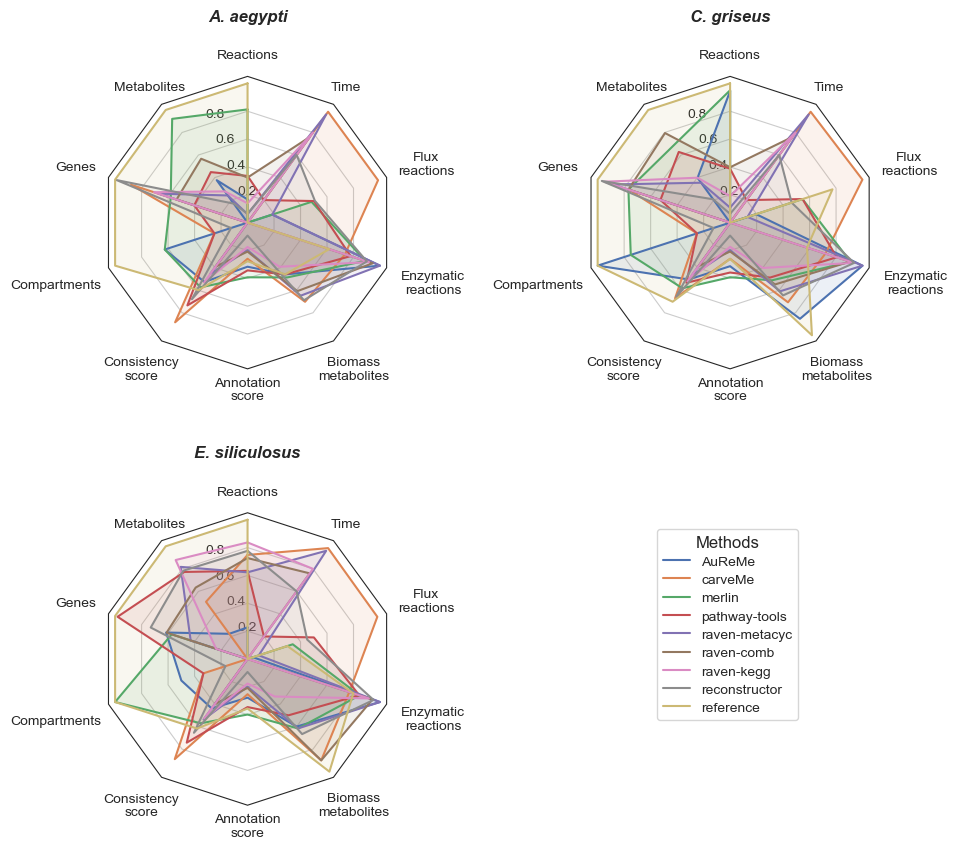

In [36]:
import copy

# The data_plot variable is set to the generated data. This variable can be used later for plotting or further processing. 
# Using a deep copy avoids modifying the data variable when manipulating the data_plot variable.
data_plot = copy.deepcopy(data)

# The data_plot variable is set to the generated data. This variable can be used later for plotting or further processing.
#data_plot = data

# General plot attributes
spoke_labels = data_plot.pop(0)
N =len(spoke_labels)
theta = radar_factory(N, frame='polygon')
fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2, subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.65, hspace=0.2, top=0.85, bottom=0.05)

#fig.subplots_adjust(wspace=0.55, hspace=0.4, top=0.85, bottom=0.05) Original parameters

# Radius for each label of the radar plot
label_radii = [1.2, 1.2, 1.3, 1.45, 1.3, 1.2, 1.3, 1.4, 1.35, 1.2] #same length as spoke_labels

# Define colors for different datasets
colors = sns.color_palette("deep", len(mega_df.columns)) 

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data_plot):
    if not title =='M_pyrifera': #Exclude M. pyrifera from analysis
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

        # Setting titles for each panel
        ax.set_title(title.replace('_', '. ').replace('CHO', 'C. griseus'), weight='bold', style='italic', size='large',
             ha='center', va='bottom', y=1.15)
        
        #Setting titles for each panel (Old way)
        #ax.set_title(title.replace('_', '. ').replace('CHO', 'C. griseus'), weight='bold',style='italic', size='medium', position=(0.5, 1.1),
        #        horizontalalignment='center', verticalalignment='center')
        
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_') 
        
        #Setting labels for each corner
        ax.set_varlabels(spoke_labels, label_radii=label_radii)
        
        #Old way for setting labels for each corner
        #ax.set_varlabels(spoke_labels) 
        
axs[1, 1].axis('off')

# Add legend relative to top-left plot
to_plot_labels = [m.replace('raven','raven_metacyc') if len(m)==len('raven') else m.replace('raven_homo','raven_kegg')
                  for m in mega_df.columns]
to_plot_labels = [m.replace('_','-') for m in to_plot_labels]

labels = (to_plot_labels) #mega_df.columns

# Add legend with title
legend = axs[0, 0].legend(
    labels,
    loc=(1.9, -1.2),  #This can be adjusted for positioning
    labelspacing=0.4,
    fontsize='medium',
    title='Methods',
    title_fontsize='large'
)

# Add legend (old way)
#legend = axs[0, 0].legend(labels, loc=(1.9, -1.2), labelspacing=0.2, fontsize='small')

# Saving results
plt.savefig('figures/Figure1.png', dpi=300) 

# Plot
plt.show()

### 1.3.3 Save radar plot to figures folder

In [42]:
# Saving results
plt.savefig('figures/Figure1.png', dpi=300) 

<Figure size 640x480 with 0 Axes>

### 1.3.2 Storing metrics in Supplementary Table

In [37]:
new_df_dict = dict()
orgs = ['A_aegypti', 'CHO', 'E_siliculosus']

for org in orgs: # Keep desired organisms
    for c in mega_df.columns:
        new_df_dict['organism'] = org.replace('_', '. ')
        new_df_dict[c] = mega_df[c][org]
    
    new_df = pd.DataFrame.from_dict(new_df_dict)
    new_df.dropna(axis=1)

    # Write as CSV
    new_df.to_csv('supplementary_material/metrics_summary_' + org+'.csv')

# 2. Biomass metabolite presence and producibility analysis 
Presence and producibility of reference biomass metabolites in draft GEM is assessed and compared (Fig.2). Also, reference GEM biomass composition is summarized (Fig. S4).

## 2.1 Summarizing reference GEM biomass composition

In [38]:
# Load reference classified biomass metabolites for each organism
file = open("biomass_analysis/met_ref_class.json")
met_ref = json.load(file)

# Create a dictionary for the reference biomass with the number of metabolites for each category (Super classes)
met_ref_class = {}
super_classes = ["Organic acids", "Nucleic acids", "Lipids", "Inorganic compounds", "Carbohydrates"]

for org, mets in met_ref.items():
    met_class_num = {super_class: 0 for super_class in super_classes}
    for met in mets:
        met_class = met.get("Super class") # There are three classifications: Super class, Main class and Sub class. We choose the first one.
        if met_class not in met_class_num:
            met_class_num[met_class] = 0
        met_class_num[met_class] += 1
    #if org=='CHO':
    #    org = 'C_griseus'
    #org = org.replace('_', '. ') #causes conflicts with further plots
    met_ref_class[org] = met_class_num

In [39]:
met_ref_class

{'A_aegypti': {'Organic acids': 20,
  'Nucleic acids': 8,
  'Lipids': 6,
  'Inorganic compounds': 1,
  'Carbohydrates': 1},
 'CHO': {'Organic acids': 20,
  'Nucleic acids': 8,
  'Lipids': 11,
  'Inorganic compounds': 1,
  'Carbohydrates': 1},
 'E_siliculosus': {'Organic acids': 26,
  'Nucleic acids': 0,
  'Lipids': 0,
  'Inorganic compounds': 0,
  'Carbohydrates': 4},
 'M_pyrifera': {'Organic acids': 26,
  'Nucleic acids': 0,
  'Lipids': 0,
  'Inorganic compounds': 0,
  'Carbohydrates': 4}}

## 2.2 Plotting reference GEM biomass composition (Fig. S4)

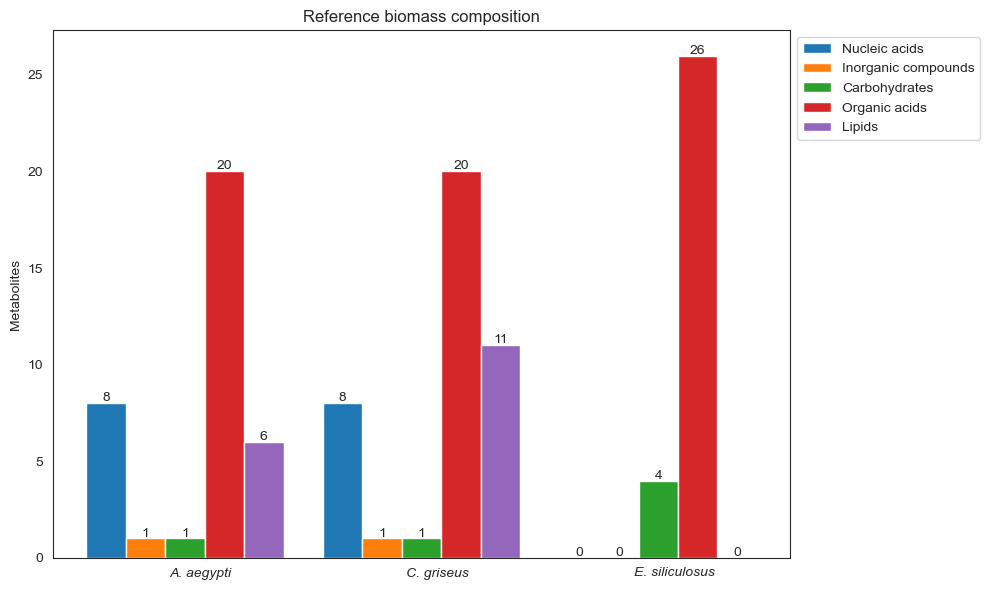

In [40]:
# Biomass reference composition: The plot
plt.rcParams.update({'font.size': 10})

# Skip M. pyrifera
if 'M_pyrifera' in met_ref_class:
    del met_ref_class['M_pyrifera']

    
# Save metabolites classifications
organisms = list(met_ref_class.keys())
metabolites = list(set(met for org in met_ref_class.values() for met in org.keys()))
metabolite_num = {met: [org.get(met, 0) for org in met_ref_class.values()] for met in metabolites}

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
bar_padding = 0
index = range(len(organisms))

for i, (metabolite, counts) in enumerate(metabolite_num.items()):
    ax.bar([x + bar_width * i/1.2  for x in index], counts, bar_width/1.2, label=metabolite)
    for j, count in enumerate(counts):
        ax.text(j + bar_width * i/1.2, count + 0.1, str(count), ha='center')

organisms = list(met_ref_class.keys())
organisms = [org.replace('_','. ') for org in organisms]
organisms = [org.replace('CHO','C. griseus') for org in organisms]
ax.set_ylabel('Metabolites')
ax.set_title('Reference biomass composition')
ax.set_xticks([x + bar_width * (len(metabolites) - 1) / 2 for x in index])
ax.set_xticklabels(organisms, style='italic')
ax.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save plot (Figure S4)
plt.savefig('supplementary_material/biomass_composition.png', dpi=300)

# Plot
plt.show()

## 2.3 Summarizing draft GEM content and producibility of reference biomass metabolites

In [41]:
# Generate two dictionaries:
# 1. Gives the number of metabolites producible, non-producible and absent for each category
# 2. Gives the number of prod and (prod + noprod) metabolites divided by the total metabolites for that category

# Load classified biomass metabolites for the draft models 
file = open("biomass_analysis/met_draft_class.json")
met_draft = json.load(file)

# Dictionary for metabolite classification present in the drafts
met_counts = {} 
all_classif = ["producible", "non-producible", "absent"]

for tool, tool_data in met_draft.items():
    for org, classifs in tool_data.items():
        # Create dictionary with every class
        for classif in all_classif:
            for super_class in {met.get("Super class") for classif, mets in classifs.items() for met in mets}:
                met_counts.setdefault(tool, {}).setdefault(org, {}).setdefault(super_class, {}).setdefault(classif, 0)
        # Count metabolites in each super class and biomass classification (absent, prod, no prod)
        for classif, mets in classifs.items():
            for met in mets:
                super_class = met.get("Super class")
                met_counts.setdefault(tool, {}).setdefault(org, {}).setdefault(super_class, {}).setdefault(classif, 0)
                met_counts[tool][org][super_class][classif] += 1
                    
# We compute the prod and (prod + no prod) normalized by the number of metabolites from the reference, first one for the 
# producibility (map color) and the second one for the metabolite presence (circle radius)
norm_met_counts = {}

for tool, org_data in met_counts.items():
    if "modelseed" not in tool: # Skip modelseed
        for org, super_class_data in org_data.items():
            if "M_pyrifera" not in org: # Skip M. pyrifera
                for super_class, classif_data in super_class_data.items():
                    total_mets = met_ref_class[org].get(super_class, 1)
                    nonprod_count = classif_data.get("non-producible", 1)
                    prod_count = classif_data.get("producible", 1)
                    prod_proportion = prod_count / total_mets
                    prod_nonprod_sum = (prod_count + nonprod_count) / total_mets

                    norm_met_counts.setdefault(tool, {}).setdefault(org, {}).setdefault(super_class, {})["prod"] = prod_proportion
                    norm_met_counts[tool][org][super_class]["prod_nonprod"] = prod_nonprod_sum

## 2.4 Plotting draft GEM content and producibility of reference biomass metabolites (Fig. 2)

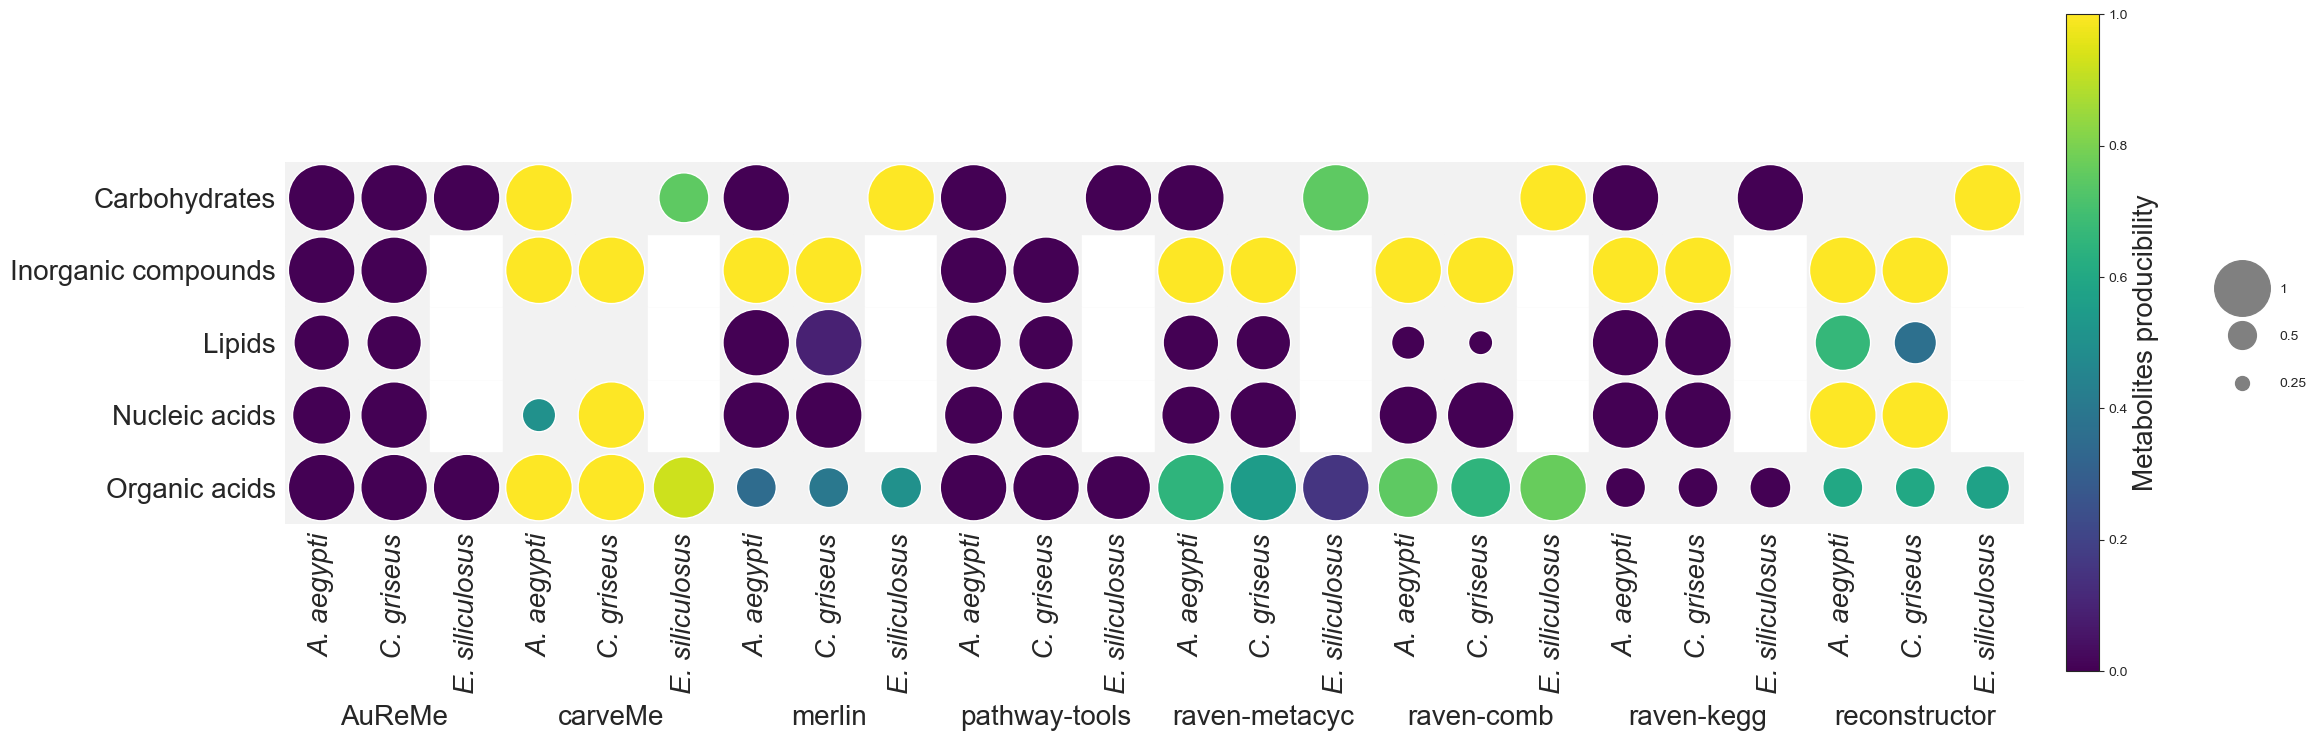

In [78]:
prefix = {'modelseed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven_homo': 'rh_',
          'raven_comb': 'rc_', 'pathway_tools': 'pt_', 'merlin': 'me_', 'carveMe': 'cv_', 'AuReMe': 'au_' }

x_label = []
y_label = []
method_names = []  # assumes same order as labels

for tool, org_data in norm_met_counts.items():
    for org, super_class_data in org_data.items():
        x_label.append(prefix[tool] + org)
        if not tool in method_names:
            method_names.append(tool)

#fix tool nomenclature for manuscript
fix_tool = {'raven': 'raven-metacyc', 'raven_homo': 'raven-kegg', 'raven_comb': 'raven-comb', 'pathway_tools': 'pathway-tools'}
for i,t in enumerate(method_names):
    if t in fix_tool.keys():
        method_names[i] = fix_tool[t]

for super_class in super_classes:
    y_label.append(super_class) 
    
x, y = np.meshgrid(np.arange(len(x_label)), np.arange(len(y_label)))

producibility_values = []
presence_values = []

# Save values for the colormap and radius
for tool, org_data in norm_met_counts.items():
    for org, super_class_data in org_data.items():
        for super_class in super_classes:
            prod_value = super_class_data.get(super_class, {}).get('prod', 0)
            prod_noprod_value = super_class_data.get(super_class, {}).get('prod_nonprod', 0)
            producibility_values.append(prod_value)
            presence_values.append(prod_noprod_value)
            
presence_values = np.array(presence_values).reshape((24, 5))

producibility = np.array(producibility_values)
presence = presence_values

fig_size = (len(x_label), len(y_label)*1.5)
fig, ax = plt.subplots(figsize=fig_size)


# Create circles regarding the metabolites "prod" or "no-prod"
circles = []

for i in range(len(x_label)):
    for j in range(len(y_label)):
        rect = Rectangle((i-0.5, j-0.5), 1, 1, color=(0.95, 0.95, 0.95))  # Light grey
        ax.add_patch(rect)
    
        radius = 0.46 * presence[i, j] # 0.46 to adjust the size
        circle = Circle((i, j), radius = radius, edgecolor=None)
        circles.append(circle)
        
        if (i % 3 in [2]) and (j in [1, 2, 3]): # Metabolites classifications absent in E. siliculosus
            #rect = Rectangle((i-0.5, j-0.5), 1, 1, color=(0.78, 0.78, 0.78)) # Grey
            rect = Rectangle((i-0.5, j-0.5), 1, 1, color=(1, 1, 1)) # white
            ax.add_patch(rect)
        

cmap = plt.get_cmap('viridis')
col = PatchCollection(circles, cmap="viridis")
col.set_array(producibility.flatten()) 

###Fix x labels
x_label = [x.replace('CHO','C_griseus') for x in x_label] #CHO -> C. griseus
x_label = [x.replace('r_', 'rm_') for x in x_label] #raven to raven metacyc
x_label = [x.replace('rh_', 'rk_') for x in x_label] #raven homo to raven kegg

#Strip method preffix from x_label
for i,label in enumerate(x_label):
    x_label[i] = label[label.find('_')+1:]
    x_label[i] = x_label[i].replace('_', '. ') #remove _ from org name

ax.add_collection(col)
ax.set(xticks=np.arange(len(x_label)), yticks=np.arange(len(y_label)),
        xticklabels=x_label, yticklabels=y_label)

ax.set_xticklabels(x_label, rotation=90)

for label in ax.get_xticklabels():
    label.set_fontstyle('italic')  # this keeps the font family but applies italic

ax.set_xticks(np.arange(len(x_label)+1)-0.5, minor=True)
ax.set_yticks(np.arange(len(y_label)+1)-0.5, minor=True)
ax.tick_params(axis='both',labelsize=20)
ax.grid(which='minor')
ax.set_aspect("equal", "box")
######horizontal labels
group_size = 3  # assuming each method has 3 organism columns

num_groups = len(x_label) // group_size

for i in range(num_groups):
    group_start = i * group_size
    group_center = group_start + (group_size - 1) / 2  # center between 3 ticks

    method = method_names[i]
    ax.text(group_center, -3, method, ha='center', va='top', fontsize=20, rotation=0)

#####

cbar = fig.colorbar(col, ax=ax, pad=0.02)
cbar.set_label('Metabolites producibility', fontsize=20)

# AaaAAAa
s1 = Line2D([0], [0], marker='o', markersize=40, color='grey', linestyle='None')
s2 = Line2D([0], [0], marker='o', markersize=20, color='grey', linestyle='None')
s3 = Line2D([0], [0], marker='o', markersize=10, color='grey', linestyle='None')
spacing = 2.5

plt.legend([s1, s2, s3], ['1', '0.5', '0.25'], bbox_to_anchor=(1.17, 0.7), frameon=False, labelspacing=spacing, handletextpad=1.7)
plt.tight_layout()
for spine in ax.spines.values():
    spine.set_visible(False)
# Save as Figure 2
plt.savefig('figures/Figure2.png', dpi=300)


#Plot
plt.show()

# 3. Compartment analysis
Compartment-specific model content is assessed and compared (Fig. 3)

## 3.1 Imports

In [79]:
import re

## 3.2 Functions

In [80]:
def compartment_analysis(sbml_file):
    # Reading the SBML model using the cobra library
    model = cobra.io.read_sbml_model(sbml_file)

    # Initializing an empty list to store reaction data
    reaction_data = []
    # Regular expression pattern to match 'or' and 'and' with surrounding spaces
    pattern = re.compile(r'\s+or\s+|\s+and\s+')
    # Iterating over each reaction in the model
    for reaction in model.reactions:
        # Extracting reactants, products, and gene-protein-reaction (GPR) rule information
        reactants = [metabolite.id for metabolite in reaction.reactants]
        products = [metabolite.id for metabolite in reaction.products]
        gpr = reaction.gene_reaction_rule
    
        # Processing reactants and products to remove suffixes
        filtered_reactants = [metabolite.rsplit('_', 1)[0] for metabolite in reactants]
        filtered_products = [metabolite.rsplit('_', 1)[0] for metabolite in products]
        compartment_list = list()
        for nc in filtered_reactants:
            for wc in reactants:
                if wc.startswith(nc):
                    compartment = wc.replace(nc, '')
                    compartment = compartment.replace('_', '')
                    compartment_list.append(compartment)
        for nc in filtered_products:
            for wc in products:
                if wc.startswith(nc):
                    compartment = wc.replace(nc, '')
                    compartment = compartment.replace('_', '')
                    compartment_list.append(compartment)
    
        compartment_list = list(set(compartment_list))
        if len(compartment_list) > 1:
            compartment_list = 'transport'
        elif len(compartment_list) > 0:
            compartment_list = compartment_list[0]
        # Splitting the GPR rule into elements and cleaning up the formatting
        gpr_elements = [element.replace('(', '').replace(')', '').replace(' ', '') for element in re.split(pattern, gpr)]
        
        # Appending the processed data to the list
        reaction_data.append([reaction.id, reactants, products, gpr, filtered_reactants, filtered_products, gpr_elements, compartment_list])
    
    # Defining column names for the DataFrame
    columns = ['ID', 'Reactants', 'Products', 'GPR', 'Filtered_Reactants', 'Filtered_Products', 'GPR_Elements', 'Compartment']
    
    # Creating a DataFrame from the list of reaction data
    df_reactions = pd.DataFrame(reaction_data, columns=columns)
    
    # Creating additional columns with sorted tuples for comparison
    df_reactions['Reactants_tuple_sorted'] = df_reactions['Filtered_Reactants'].apply(lambda x: tuple(sorted(x)))
    df_reactions['Products_tuple_sorted'] = df_reactions['Filtered_Products'].apply(lambda x: tuple(sorted(x)))
    df_reactions['GPR_Elements_tuple_sorted'] = df_reactions['GPR_Elements'].apply(lambda x: tuple(sorted(x)))
    
    # Identifying reactions with duplicate reactants and products
    df_duplicates = df_reactions[df_reactions.duplicated(subset=['Reactants_tuple_sorted', 'Products_tuple_sorted'], keep=False)]
    
    # Identifying reactions with the same GPR rule and duplicate reactants/products
    df_duplicates_2 = df_reactions[df_reactions.duplicated(subset=['GPR_Elements_tuple_sorted', 'Reactants_tuple_sorted', 'Products_tuple_sorted'], keep=False)]
    
    # Merging the two duplicate DataFrames and indicating the source of each row
    merged_df = pd.merge(df_duplicates, df_duplicates_2, on='ID', how='outer', indicator=True)
    
    # Extracting rows that are only present in the left DataFrame (differences in GPR rules)
    difference_df = merged_df[merged_df['_merge'] == 'left_only']
    
    # Selecting relevant columns for the final result
    df_final_result = difference_df.iloc[:, :10] #Why?
    
    # Filtering out rows where the GPR rule is an empty string
    df_final_result = df_final_result[df_final_result['GPR_x'].astype(str).str.strip() != '']
    
    # Filtering out rows with the same GPR rule in the second set of duplicates
    df_duplicates_2 = df_duplicates_2[df_duplicates_2['GPR'].astype(str).str.strip() != '']
    result = dict()
    # Printing the number of reactions with different GPR rules among duplicates
    num_final_result_rows = df_final_result.shape[0]
    print("Duplicated reactions different GPR: ", num_final_result_rows)
    result['Duplicated reactions different GPR'] = num_final_result_rows
    # Printing the number of reactions with the same GPR rule among duplicates
    num_duplicates_2_rows = df_duplicates_2.shape[0]
    
    print("Duplicated reactions same GPR:", num_duplicates_2_rows)
    result['Duplicated reactions same GPR'] = num_duplicates_2_rows
    # Printing the total number of reactions with duplicates
    num_duplicates_rows = df_duplicates.shape[0]
    print("Duplicated reactions:", num_duplicates_rows)
    result['Duplicated reactions'] = num_duplicates_rows
    # Filtering out rows without a GPR rule in the first set of duplicates
    df_duplicates = df_duplicates[df_duplicates['GPR'].astype(str).str.strip() != '']
    
    # Printing the total number of reactions with duplicates and a GPR rule
    num_duplicates_rows = df_duplicates.shape[0]
    print("Duplicated reactions with GPR:", num_duplicates_rows)
    result['Duplicated reactions with GPR'] = num_duplicates_rows
    dfs = [df_duplicates, df_duplicates_2] # df_duplicates: reactions different GPR among duplicates, df_duplicates_2: same GPR rule
    return result, dfs

## 3.3 Analysis

In [81]:
# Generation of compartment_analysis.csv using the compartment_analysis function

## 3.4 Plotting

### Fig.3 (left)
Classification of duplicated reactions according to GPR, for all GEMs

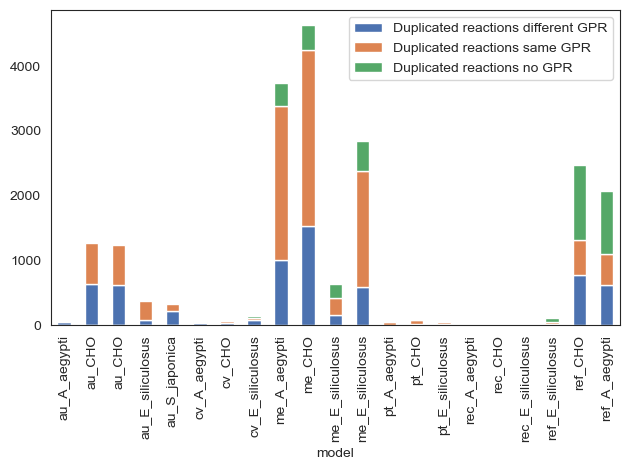

In [82]:
file_path = 'compartment_analysis/compartment_analysis.csv'
comp_df = pd.read_csv(file_path, sep=';')
sns.set_palette("deep")

comp_df.index = comp_df['model']

#Exclude organisms distinct from CHO, A. aegypti and E. siliculosus
comp_df = comp_df[comp_df['Organism']!= 'M_pyrifera']
comp_df = comp_df[comp_df['Organism']!= 'S_japonica']

#Exclude modelSEED method
comp_df = comp_df[comp_df['Tool']!= 'Modelseed']

fig = comp_df.plot.bar(stacked=True).figure
fig.tight_layout()

#Save as Figure 3 (left)
fig.savefig("figures/Figure3_left.png", dpi=300) 

### Fig. 3 (right)
More detailed Figure for some GEMs with low number of duplicated reactions

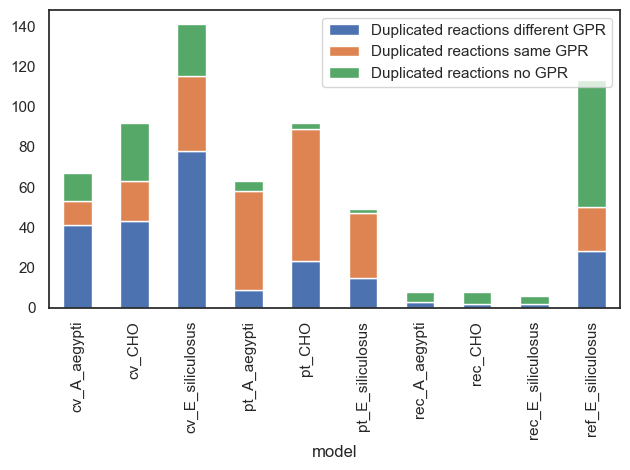

In [170]:
#Only keep models with low number of duplicated reactions (cv, pt, rec and E. siliculosus reference)
plot_df = comp_df[comp_df['Tool']!= 'AuReMe']
plot_df = plot_df[plot_df['Tool']!= 'Merlin']
plot_df = plot_df[plot_df['Tool']!= 'Modelseed']
plot_df = plot_df[plot_df['model']!= 'ref_CHO']
plot_df = plot_df[plot_df['model']!= 'ref_A_aegypti']

fig = plot_df.plot.bar(stacked=True).figure
fig.tight_layout()

# Save as Figure 3 (right)
fig.savefig("figures/Figure3_right.png", dpi=300) 

# 4. Specialized metabolite analysis
Organism-specific metabolite content is assessed and compared (Fig. 4)

## 4.1 Load metabolites for each organism

In [171]:
#Load metabolites for E. siliculosus
name_df = pd.read_csv('./specialized_metabolites/Alga_name_id.txt').dropna()
list_ES = list(name_df['KEGG'].dropna().unique())

k_df = pd.read_csv('./specialized_metabolites/Alga_KEGG_ids.txt')
list_ES.extend(list(k_df['KEGG'].dropna().unique()))
len(k_df['KEGG'].dropna().unique())
list_ES = list(set(list_ES))

#Load metabolites for A. aegypti
name_df = pd.read_csv('./specialized_metabolites/Aedes_name_id.txt').dropna()
list_AA = list(name_df['KEGG'].dropna().unique())

#Load metabolites for CHO
name_df = pd.read_csv('./specialized_metabolites/CHO_name_id.txt').dropna()
list_CHO = list(name_df['KEGG'].dropna().unique())

## 4.2 Identify exclusive metabolites for each organism

In [172]:
#Convert lists to sets for facilitating set operations
aedes = set(list_AA)
CHO = set(list_CHO)
ecto = set(list_ES)

#Compute elements that are exclusively in a specific organism
new_aedes = aedes - CHO - ecto
new_CHO = CHO - aedes - ecto
new_ecto = ecto - aedes - CHO

#Summarize exclusive metabolites for each organism 
kegg_dict = {'A_aegypti': list(new_aedes), 'CHO': list(new_CHO), 'E_siliculosus': list(new_ecto)}

## 4.3 Compute present metabolites for each organism, for each method

In [173]:
# Initialize mega_dict to store metabolites, for models generated for each organism, using each method.

#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method, such as loaded cobrapy model and metabolite ids

mega_dict = dict()

# List of methods
methods = ['AuReMe', 'carveMe', 'merlin', 'modelseed', 'raven_homo', 'reconstructor', 'raven', 'raven_comb', 'pathway_tools', 'reference']
methods = ['reference']

# Dictionary mapping each method to its corresponding database(s)
db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"], 'reference': ['metacyc', "bigg", "kegg", "modelseed"]}

for method in methods:
    if not method.startswith('.'):
        method_dict = dict()
        print(method)
        for org in os.listdir('./models/'+method):
            if not org.startswith('.'): #Exclude hidden files
                org_dict = dict()
                print(org)
                
                # Load model cobrapy
                sbml_path = './models/'+method+'/'+org
                if not 'M_pyrifera' in sbml_path:
                    model = cobra.io.read_sbml_model(sbml_path) 
                    org_dict['model'] = model
                    
                    # Store list of metabolites and metabolite participation
                    met_dict = dict()
                    par_dict = dict()
                    met_list = [m.id for m in model.metabolites]
                    db_out = 'kegg'#map all models to kegg
                    
                    for this_db in db_dict[method]:
                        print(this_db)
                        if not this_db=='kegg':
                
                            map_dict = map_metabolites(met_list, sbml_path, this_db, db_out, mnx_only=False)
                    
                            for m in map_dict.keys():
                                met_dict[map_dict[m]] = 1
    
    
                    org_dict['metabolites'] = met_dict
                    org_string = org.replace('.xml','')
                    org_string = org_string.replace('.sbml','')
                    method_dict[org_string] = org_dict

            mega_dict[method] = method_dict

reference
A_aegypti.xml
metacyc


FileNotFoundError: [Errno 2] No such file or directory: './DB/chem_xref.tsv'

## 4.4 TO RESOLVE

In [ ]:
for k in mega_dict.keys():
    this_db = db_dict[k]
    print(this_db)
    if 'kegg' in this_db: #should be if ['kegg'] in this_db
        print('Debug')
        if mega_dict[k] < mega_dict2[k]:
            mega_dict[k] = mega_dict2[k] #if not mapped in first iter, then include info from second

#-----------------------------

prefix = {'modelseed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven_homo': 'rh_', 'raven_comb': 'rc_', 
         'pathway_tools': 'pt_', 'merlin': 'me_', 'carveMe': 'cv_', 'AuReMe': 'au_', 'reference': 'ref_' }

dbs2plot = {'raven': 'metacyc', 'raven_homo': 'kegg', 'raven_comb': 'metacyc-kegg' , 'pathway_tools': 'metacyc',
          'merlin': 'kegg', 'carveMe': 'bigg', 'reconstructor': 'modelseed', 'modelseed': 'modelseed', 
           "AuReMe": 'other'}

dbs_plot = dict()
df_dict = dict()
model_names =[]
for m in methods:
    method_dict = mega_dict[m]
    for org in method_dict.keys():
        this_org = method_dict[org]
        df_dict[prefix[m]+org] = this_org['metabolites']
        model_names.append(prefix[m]+org)
        #dbs_plot[prefix[m]+org] = dbs2plot[m]
        #df_dict[org] = this_org['reactions']

#-----------------------------

df_KEGG = pd.DataFrame.from_dict(df_dict).fillna(0)

#df_KEGG.to_csv('models_to_KEGG.csv')
df_KEGG.to_csv('refs_KEGG.csv')

df_KEGG = pd.read_csv('./specialized_metabolites/models_to_KEGG.csv', index_col=0)

df_KEGGref = pd.read_csv('./specialized_metabolites/refs_KEGG.csv', index_col=0)

df_KEGG = pd.concat([df_KEGG, df_KEGGref]).fillna(0)

df_core = df_KEGG[df_KEGG[:].nunique(axis=1) == 1]

#------------------------------

orgs = ['A_aegypti', 'CHO', 'E_siliculosus']
map_dict = dict()
total_dict = dict()
detail_common = dict()
for org in orgs:
    common = list(set(df_KEGG.index).intersection(set(kegg_dict[org]))) #metabolites present in both dataframe models and set to map
    total_dict[org] = len(common)
    map = df_KEGG.loc[common].sum()
    ids_map = dict()
    for col in df_KEGG.columns:
        filter_df = df_KEGG[col]
        filter_df = filter_df.loc[common]
        mapped = filter_df[filter_df>0].index.to_list()
        ids_map[col] = mapped
    map_dict[org] = map.to_dict()
    detail_common[org]  = ids_map

#--------------------------------

df_map_spe_mets = pd.DataFrame.from_dict(map_dict)

df_map_spe_mets.plot.bar(subplots=True, legend=None)

df_KEGG = df_KEGG.reindex(sorted(df_KEGG.columns), axis=1)

re_org_cols = ['au_A_aegypti', 'au_CHO', 'au_E_siliculosus', 'cv_A_aegypti', 'cv_CHO',
       'cv_E_siliculosus', 'me_A_aegypti', 'me_CHO', 'me_E_siliculosus',
       'pt_A_aegypti', 'pt_CHO', 'pt_E_siliculosus', 'r_A_aegypti', 'r_CHO',
       'r_E_siliculosus', 'rc_A_aegypti', 'rc_CHO', 'rc_E_siliculosus',
        'rh_A_aegypti', 'rh_CHO', 'rh_E_siliculosus', 'rec_A_aegypti', 'rec_CHO', 'rec_E_siliculosus', 'ref_A_aegypti',
       'ref_CHO', 'ref_E_siliculosus' ]

df_KEGG = df_KEGG[re_org_cols]

## 4.5 Prepare visualization (Fig. 4)

In [ ]:
# Extended dataframe with structure for seaborn plot, includes core metabolite mapping
orgs = ['A_aegypti', 'CHO', 'E_siliculosus']
prefix_rev = {'ms': 'modelSEED', 'rec': 'reconstructor', 'r': 'raven', 'rh': 'raven homo', 'rc': 'raven comb', 
              'pt': 'pathway tools', 'me': 'merlin', 'cv': 'carveMe', 'au': 'AuReMe', 'ref': 'reference' }
map_dict = dict()
total_dict = dict()
detail_common = dict()
df_dict = dict() #dict with dataframe
index = 0
core_spec = set(kegg_dict['A_aegypti']) & set(kegg_dict['CHO']) & set(kegg_dict['E_siliculosus'])
for org in orgs:
    common = list(set(df_KEGG.index).intersection(set(kegg_dict[org]))) #metabolites present in both dataframe models and set to map
    total_dict[org] = len(common)
    map = df_KEGG.loc[common].sum()
    ids_map = dict()
    for col in df_KEGG.columns:
        row_dict = dict()
        #model, type (total/core), metabolites (number), organism (from which specialized metabolites are mapped)
        filter_df = df_KEGG[col]
        filter_df = filter_df.loc[common]
        mapped = filter_df[filter_df>0].index.to_list()
        ids_map[col] = mapped
        row_dict['model'] = col
        row_dict['Method'] = prefix_rev[col.split('_')[0]]
        xx, modeled_org = col.split('_',1)
        row_dict['Model org'] = modeled_org.replace('_','. ')
        row_dict['type'] = 'total'
        row_dict['metabolites'] = len(mapped)
        row_dict['organism'] = org.replace('CHO','C. griseus').replace('_','. ')
        df_dict[index] = row_dict
        index = index + 1
        
    map_dict[org] = map.to_dict()
    detail_common[org]  = ids_map

df_map_spe_mets = pd.DataFrame.from_dict(df_dict, orient='index')

## 4.6 Visualization (Fig. 4)

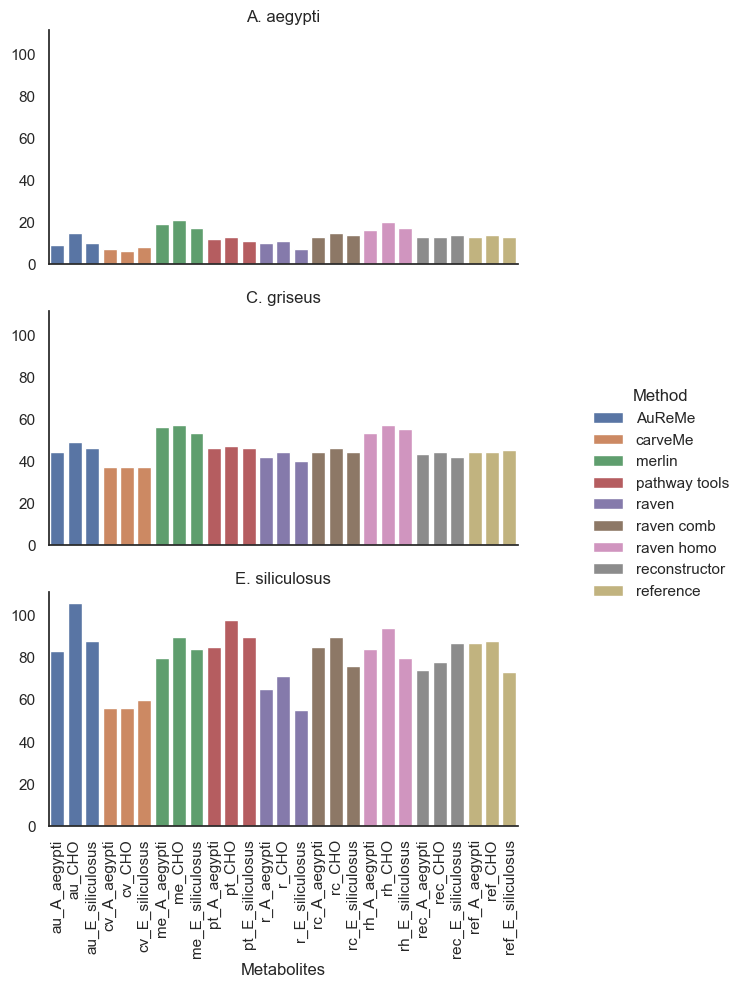

In [101]:
sns.set_theme(style="white", palette="deep")
g = sns.catplot(
    df_map_spe_mets, kind="bar",
    x="model", y="metabolites", hue='Method', row="organism",
    height=3, aspect=2, dodge=False
)
g.set_axis_labels("Metabolites", "")
g.set_titles("{row_name}")
g.tight_layout()
g.tick_params(axis='x', labelrotation=90)

# Save as Figure 4
g.savefig("figures/Figure4.pdf")

# 5. Model content comparison
Overall model content (reactions and metabolites) is compared (Fig. 5)

## 5.1 Imports

In [26]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from adjustText import adjust_text
import fastcluster
from skbio.stats.ordination import pcoa
from collections import defaultdict
import csv

## 5.2 Functions

### compute_mapping_stats
Receives a summary -reaction or metabolite- mapping table (csv), and computes the number of total unique IDs, 'MNX' unique IDs and percetage of effectively mapped IDs, for each mapped model. Exports the results into a csv table.

In [27]:
def compute_mapping_stats(summary_mapping_table_path, id_type, output_path):
    """
    Receives a summary <reaction or metabolite> mapping table (csv), and it computes the number of total unique IDs, 'MNX' unique IDs and 
    percetage of effectively mapped IDs, for each mapped model. Exports the results into a csv table.
    """
    model_stats = defaultdict(lambda: {"total": set(), "mnx": set()})

    with open(summary_mapping_table_path, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)

        for row in csv_reader:
            if id_type=="rxn" and row['transport'] in ['1', 1]:
                continue  # Filter out rows where transport is 1

            model = row['model']
            final_id = row['Final ID']
            model_stats[model]["total"].add(final_id)

            if final_id.startswith("MNX"):
                model_stats[model]["mnx"].add(final_id)

    # Prepare data for exporting stats
    stats_rows = []
    for model, data in model_stats.items(): 
        total_count = len(data["total"])
        mnx_count = len(data["mnx"])
        mnx_percentage = (mnx_count / total_count * 100) if total_count > 0 else 0

        stats_rows.append({
            "model": model,
            "total_unique_ids": total_count,
            "total_mnx_ids": mnx_count,
            "mapping_percentage": f"{mnx_percentage:.2f}"
        })

    # Export the stats to a CSV file
    with open(output_path, mode='w', newline='') as csv_file:
        fieldnames = ["model", "total_unique_ids", "total_mnx_ids", "mapping_percentage"]
        csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        csv_writer.writeheader()
        csv_writer.writerows(stats_rows)

### plot_pcoa
Receives a binary matrix, a two dictionaries mapping models to databases and organisms, to generate a PCoA.

In [42]:
def plot_pcoa(binary_matrix, model2db, model2org, feature_type, x_offset, y_offset, out_path):
    """
    Generate a PCoA with grouping by databases and organisms.
    
    Parameters:
    - binary_matrix (pd.DataFrame): A binary matrix with models as rows and features as columns.
    - models (list): List of model names corresponding to columns in binary_matrix.
    - model2db (dict): Dictionary mapping models to database modes.
    - model2org (dict): Dictionary mapping models to organisms.
    - feature_type (str): Type of feature ('metabolite' or 'reaction').
    - out_path (str): Path to output figure file
    """
    
    # Compute pairwise Jaccard distances between columns (models)
    distance_matrix = pairwise_distances(binary_matrix.values, metric='jaccard')
    
    # Perform MDS for dimensionality reduction to 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coordinates = mds.fit_transform(distance_matrix)
    
    # Compute variance explained approximation
    H = np.eye(len(distance_matrix)) - np.ones(distance_matrix.shape) / len(distance_matrix)
    B = -0.5 * H @ (distance_matrix ** 2) @ H
    eigenvalues = np.linalg.eigvalsh(B)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    variance_explained = sorted_eigenvalues[:3] / np.sum(sorted_eigenvalues)

    # Print variance explained approximation for the three first coordinates
    print(f"PC1 ({variance_explained[0]:.1%})\n")
    print(f"PC2 ({variance_explained[1]:.1%})\n")
    print(f"PC3 ({variance_explained[2]:.1%})\n")
    
    # Compute transposed binary matrix
    binary_matrix_t = binary_matrix.T
    
    # Create a DataFrame for easy plotting
    model_coords = pd.DataFrame(
        coordinates, 
        columns=[f"PC1 ({variance_explained[0]:.1%})", f"PC2 ({variance_explained[1]:.1%})"], 
        index=binary_matrix_t.columns
    )
    
    # Annotate model's features (for grouping)
    model_coords['Tool'] = [model.split('_')[0] for model in model_coords.index]
    model_coords['Mode'] = [model2db[model] for model in model_coords.index]
    model_coords['Organism'] = [model2org[model] for model in model_coords.index]
    
    # Define color and shape mappings
    db_colors = sns.color_palette("muted", len(set(model_coords['Mode'])))
    db_colors = dict(zip(set(model_coords['Mode']), db_colors))
    
    org_shapes = {"A_aegypti": "D", "C_griseus": "s", "E_siliculosus": "o"}  # Example shapes
    
    # Create the plot using seaborn scatterplot
    plt.figure(figsize=(10, 8))
    
    sns.scatterplot(
        data=model_coords, 
        x=model_coords.columns[0], 
        y=model_coords.columns[1], 
        hue='Mode', 
        style='Organism', 
        palette=db_colors, 
        markers=org_shapes, 
        s=100, 
        edgecolor='none' #used to be black
    )
    
    # Add sample names with text offsets
    texts = []
    for i, sample_name in enumerate(model_coords.index):
        texts.append(
            plt.text(
                model_coords.iloc[i, 0] + x_offset,
                model_coords.iloc[i, 1] + y_offset,
                sample_name.split('_')[0],
                fontsize=11,
                ha='center',
            )
        )
    
    adjust_text(
        texts,
        expand_points=(1.2, 1.2),
        expand_text=(1.4, 1.4),
        force_text=0.5,
        force_points=0.3,
    )
    
    # Reposition the legend
    plt.legend(
        title="Legend", 
        loc="upper left", 
        bbox_to_anchor=(1.15, 1), 
        fontsize=11,
        title_fontsize=12
    )
    
    # Title and labels
    plt.title("PCoA plot of " + feature_type + " contents", fontsize=16, pad=20)
    plt.xlabel(model_coords.columns[0], fontsize=14)
    plt.ylabel(model_coords.columns[1], fontsize=14)
    
    plt.grid(True)
    plt.tight_layout()

    # Save as figure
    if out_path is not None:
        plt.savefig(out_path, dpi=300)
    
    plt.show()

### plot_biclustered_heatmap
Receives a binary matrix with samples (models) as rows and features (reactions or metabolites) as columns, a list of models, and two dictionaries mapping models to databases and organisms, and generate a biclustered heatmap.

In [29]:
def plot_biclustered_heatmap(binary_matrix, models, model2db, model2org, feature_type, out_path):
    """
    Generate a biclustered heatmap with colored annotations for databases and organisms.
    
    Parameters:
    - binary_matrix (pd.DataFrame): A binary matrix with models as rows and features as columns.
    - models (list): List of model names corresponding to columns in binary_matrix.
    - model2db (dict): Dictionary mapping models to database modes.
    - model2org (dict): Dictionary mapping models to organisms.
    - feature_type (str): Type of feature ('metabolite' or 'reaction').
    - out_path (str): Path to output figure file
    """
    
    # Create color mappings for databases and organisms
    db_unique = list(set(model2db.values()))
    db_colors = dict(zip(db_unique, sns.color_palette("muted", len(db_unique))))
    org_unique = list(set(model2org.values()))
    org_colors = dict(zip(org_unique, sns.color_palette("pastel", len(org_unique))))

    # Create color bars for the heatmap
    col_colors_db = pd.Series([db_colors[model2db[model]] for model in models], index=models)
    col_colors_org = pd.Series([org_colors[model2org[model]] for model in models], index=models)
    col_colors = pd.DataFrame({'Database': col_colors_db, 'Organism': col_colors_org})

    # Transpose to set models as columns and metabolites as rows
    binary_matrix_t = binary_matrix.T

    # Create the clustermap
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 10))

    clustergrid = sns.clustermap(
        binary_matrix_t,
        cmap="Greys",
        col_cluster=True,
        row_cluster=True,
        metric="jaccard",
        dendrogram_ratio=(0.2, 0.2),
        cbar_pos=None,
        yticklabels=False,
        col_colors=col_colors
    )

    # Create legend patches
    db_legend_patches = [mpatches.Patch(color=color, label=label) for label, color in db_colors.items()]
    org_legend_patches = [mpatches.Patch(color=color, label=label) for label, color in org_colors.items()]

    # Create legends in separate axes
    legend_ax_db = clustergrid.fig.add_axes([0.85, 0.5, 0.1, 0.1])
    legend_ax_org = clustergrid.fig.add_axes([0.85, 0.3, 0.1, 0.1])

    legend_ax_db.axis('off')
    legend_ax_org.axis('off')

    legend_ax_db.legend(
        handles=db_legend_patches,
        title="Databases",
        loc='upper left',
        fontsize=10,
        title_fontsize=11
    )

    legend_ax_org.legend(
        handles=org_legend_patches,
        title="Organisms",
        loc='upper left',
        fontsize=11,
        title_fontsize=11
    )

    # Adjust layout for better spacing
    plt.suptitle('Biclustered heatmap of ' + feature_type + ' contents', fontsize=16, y=0.92)
    plt.subplots_adjust(top=0.85, right=0.8)

    # Rotate column labels
    plt.setp(clustergrid.ax_heatmap.xaxis.get_majorticklabels(), rotation=50, ha="right")

    # Save as figure
    if out_path is not None:
        plt.savefig(out_path, dpi=300)

    # Show the plot
    plt.show()

## 5.3 Mapping metabolites and reactions
This section maps metabolites and reactions from each draft GEM into the MetaNetX namespace. Two complementary methods were used for mapping, "direct" and "mergem", which are described in Methods in the manuscript. The outputs of this section were then manually curated (particularly, the results from the two mapping methods were reconciled). This semi-automated process generates the 'complete_rxn_mapping.csv' and 'complete_met_mapping.csv' files, which are used for further analysis and visualization of model contents.

### 5.3.1 Direct mapping

### 5.3.2 Mergem mapping

In [ ]:
%run mergem_mapping.ipynb

Running mergem_mapping effectively


Loading SBML model without fbc:strict="true"
Loading SBML with fbc-v1 (models should be encoded using fbc-v2)
No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized
Loading SBML model without fbc:strict="true"
Loading SBML with fbc-v1 (models should be encoded using fbc-v2)
No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized
Loading SBML model without fbc:strict="true"
Loading SBML with fbc-v1 (models should be encoded using fbc-v2)
No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized
10029 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
7159 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
2880 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
Model does not contain SBML fbc p

## 5.4 Computing reaction and metabolite mapping stats

In [178]:
# Generate reacion mapping stats
complete_rxn_mapping_path = 'mappings/complete_rxn_mapping.csv' # Path to the reaction mapping table 
rxn_mapping_stats_path = 'supplementary_material/rxn_mapping_stats.csv'  # Path to save the reaction mapping stats file
compute_mapping_stats(complete_rxn_mapping_path, 'rxn' , rxn_mapping_stats_path)

# Generate metabolite mapping stats
complete_met_mapping_path = 'mappings/complete_met_mapping.csv' # Path to the metabolite mapping table
met_mapping_stats_path = 'supplementary_material/met_mapping_stats.csv'  # Path to save the metabolite mapping stats file
compute_mapping_stats(complete_met_mapping_path, 'met' , met_mapping_stats_path)

## 5.5 Model reaction content plotting (without AuReMe tests)

### 5.5.1 Reading complete reaction mapping table

In [30]:
# Path to complete reaction mapping table
complete_rxn_mapping_table_path = 'mappings/complete_rxn_mapping.csv'

# Read original csv
df = pd.read_csv(complete_rxn_mapping_table_path)

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Print first entries
print('Dataframe header: \n',df.head(5),'\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (113367, 10) 

Dataframe header: 
                            Original ID                         MNX_raw_SMej  \
0        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
1        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
2           _MENTHOL_DEHYDROGENASE_RXN           _MENTHOL_DEHYDROGENASE_RXN   
3  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   
4  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   

  transport                             MNX_SMej         model  \
0         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_A_aegypti   
1         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_C_griseus   
2         0           _MENTHOL_DEHYDROGENASE_RXN  rc_C_griseus   
3         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_A_aegypti   
4         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_C_griseus   

                          cleaned_SMen    MNX_SMen  MNX_manual    MNX_auto  

C:\Users\futbo\AppData\Local\Temp\ipykernel_68900\3734278522.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(complete_rxn_mapping_table_path)


### 5.5.2 Filtering models

In [31]:
# Define models to exclude (AuReMe tests and modelSEED)
excluded_models = ['au2_A_aegypti', 'au3_A_aegypti', 'au4_A_aegypti',
                   'au2_C_griseus', 'au3_C_griseus', 'au4_C_griseus', 'au5_C_griseus',
                   'au2_E_siliculosus', 'au3_E_siliculosus', 'au4_E_siliculosus', 'au5_E_siliculosus',
                   'ms_A_aegypti', 'ms_C_griseus', 'ms_E_siliculosus']

# Filtering
df = df[~df['model'].isin(excluded_models)]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')
print(unique_models)

Dataframe size:  (68323, 10) 

Number of unique reactions:  13736 

Number of unique models:  27 

['rc_A_aegypti' 'rc_C_griseus' 'rc_E_siliculosus' 'au_A_aegypti'
 'au_C_griseus' 'au_E_siliculosus' 'pt_C_griseus' 'pt_E_siliculosus'
 'r_A_aegypti' 'r_C_griseus' 'r_E_siliculosus' 'pt_A_aegypti'
 'cv_E_siliculosus' 'cv_C_griseus' 'cv_A_aegypti' 'me_C_griseus'
 'me_E_siliculosus' 'me_A_aegypti' 'rh_A_aegypti' 'rh_C_griseus'
 'rh_E_siliculosus' 'rec_E_siliculosus' 'rec_C_griseus' 'rec_A_aegypti'
 'ref_A_aegypti' 'ref_C_griseus' 'ref_E_siliculosus']


### 5.5.3 Filtering transport reactions

In [32]:
# Filter transport reactions
df = df[df['transport']!=1]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (66455, 10) 

Number of unique reactions:  13510 

Number of unique models:  27 



### 5.5.4 Constructing binary matrix representing reaction presence

In [33]:
# Initialize a DataFrame with rows as models and columns as unique_rxns
binary_matrix = pd.DataFrame(0, index=unique_models, columns=unique_rxns)

for model in unique_models:
    # Get unique reactions for each model
    model_rxns = df[df['model'] == model]['Final ID'].dropna().unique()
    
    # Set the binary matrix values to 1 for the reactions in the current model
    binary_matrix.loc[model, model_rxns] = 1

# Fill NaNs with 0 for reactions that are not present in a model
binary_matrix = binary_matrix.fillna(0)
print(binary_matrix[0:5][1:5])

                  MNXR145864  MNXR107350  MNXR114877  MNXR114878  MNXR114879  \
rc_C_griseus               1           1           1           1           1   
rc_E_siliculosus           0           1           1           1           1   
au_A_aegypti               0           0           0           1           1   
au_C_griseus               0           0           0           1           1   

                  MNXR138245  MNXR107592  MNXR148054  MNXR114882  MNXR148641  \
rc_C_griseus               0           1           1           1           1   
rc_E_siliculosus           1           0           0           1           0   
au_A_aegypti               0           1           0           0           0   
au_C_griseus               0           1           0           0           0   

                  ...  MNXR144150  3.2.1.39-RXN  MNXR152519  MNXR122662  \
rc_C_griseus      ...           0             0           0           0   
rc_E_siliculosus  ...           0             0 

In [34]:
binary_matrix.shape

(27, 13510)

### 5.5.5 Labeling models for grouping

In [35]:
# Extract model names from the index of the binary matrix
models = binary_matrix.index

# Model to database mapping based on tool (model prefix)
tool2db = {'r': 'metacyc', 'rh': 'kegg', 'rc': 'metacyc-kegg', 'pt': 'metacyc', 
           'me': 'kegg', 'cv': 'bigg', 'rec': 'modelseed', 'au': 'metacyc-reference', 'ref': 'reference'}
model2db = {}
for model in models:
    prefix = model.split('_')[0]
    model2db[model] = tool2db[prefix]

# Model to organism mapping (based on model suffix)
model2org = {model: '_'.join(model.split('_')[-2:]) for model in models}

### 5.5.6 Plotting heatmap

<Figure size 1200x1000 with 0 Axes>

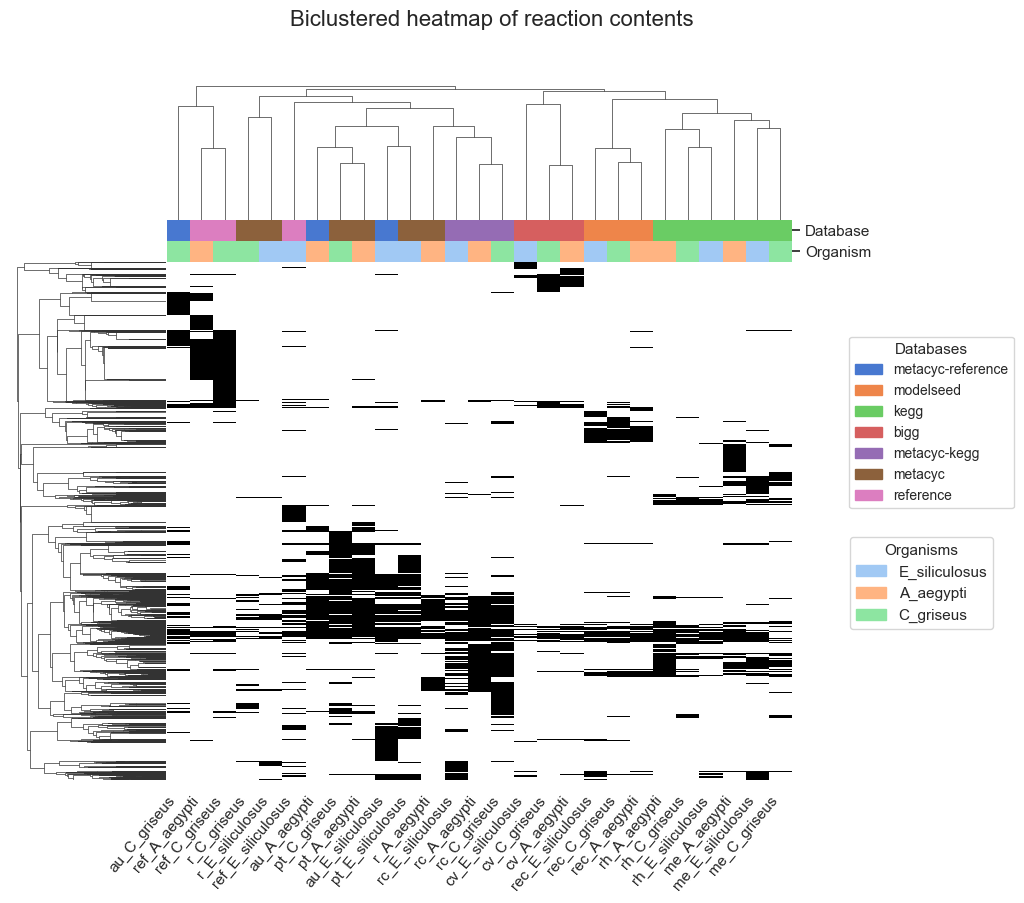

In [36]:
import sys
sys.setrecursionlimit(10000)  # Increase recursion depth

# Plot with saving
plot_biclustered_heatmap(binary_matrix, models, model2db, model2org, 'reaction', 'figures/Figure5a.png')

### 5.5.7 Plotting PCoA

C:\Users\futbo\miniconda3\envs\eukaryo_methods_env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


PC1 (17.0%)

PC2 (12.4%)

PC3 (8.7%)



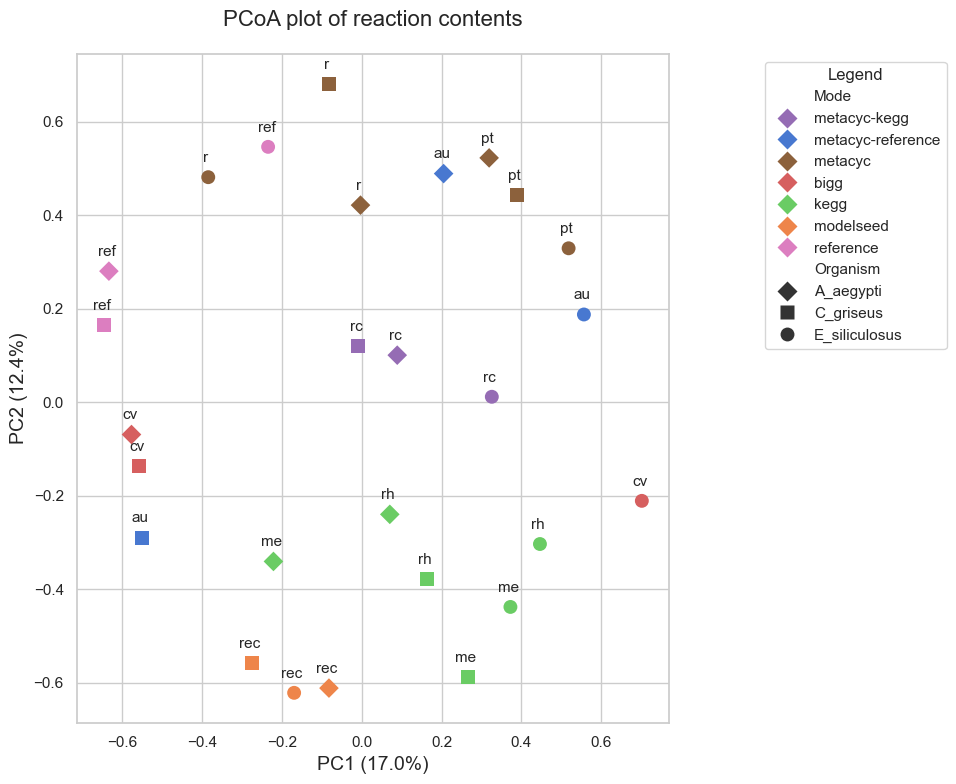

In [43]:
plot_pcoa(binary_matrix, model2db, model2org, 'reaction', 0.0, 0.02, 'figures/Figure5b.png')

## 5.6 Model metabolite content plotting (without AuReMe tests)

### 5.6.1 Reading complete metabolite mapping table

In [44]:
# Read complete metabolite mapping table
complete_met_mapping_table_path = 'mappings/complete_met_mapping.csv'

# Read original csv
df = pd.read_csv(complete_met_mapping_table_path)

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Print first entries
print('Dataframe header: \n',df.head(5),'\n')

# Find unique metabolites
unique_mets = df['Final ID'].dropna().unique()
print('Number of unique metabolites: ', str(len(unique_mets)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (117284, 3) 

Dataframe header: 
                              Original ID             model    Final ID
0                           __MENTHOL[c]      rc_C_griseus    MNXM1346
1              +_5_oxo_1_2_campholide[c]      rc_A_aegypti  MNXM733701
2              +_5_oxo_1_2_campholide[c]      rc_C_griseus  MNXM733701
3              +-5-oxo-1-2-campholide[c]  rc_E_siliculosus  MNXM733701
4  1_2_DIPALMITOYLPHOSPHATIDYLCHOLINE[c]      rc_A_aegypti   MNXM32122 

Number of unique metabolites:  13238 

Number of unique models:  40 



### 5.6.2 Filtering models

In [45]:
# Define models to exclude (aureme tests and modelseed)
excluded_models = ['au2_A_aegypti', 'au3_A_aegypti', 'au4_A_aegypti',
                   'au2_C_griseus', 'au3_C_griseus', 'au4_C_griseus', 'au5_C_griseus',
                   'au2_E_siliculosus', 'au3_E_siliculosus', 'au4_E_siliculosus', 'au5_E_siliculosus',
                   'ms_A_aegypti', 'ms_C_griseus', 'ms_E_siliculosus']

# Filtering excluded models
df = df[~df['model'].isin(excluded_models)]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique metabolites
unique_mets = df['Final ID'].dropna().unique()
print('Number of unique metabolites: ', str(len(unique_mets)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')
print(unique_models)

Dataframe size:  (74382, 3) 

Number of unique metabolites:  11384 

Number of unique models:  27 

['rc_C_griseus' 'rc_A_aegypti' 'rc_E_siliculosus' 'au_A_aegypti'
 'au_C_griseus' 'au_E_siliculosus' 'pt_A_aegypti' 'pt_C_griseus'
 'pt_E_siliculosus' 'r_E_siliculosus' 'cv_A_aegypti' 'cv_C_griseus'
 'cv_E_siliculosus' 'r_C_griseus' 'r_A_aegypti' 'me_A_aegypti'
 'me_C_griseus' 'me_E_siliculosus' 'rh_A_aegypti' 'rh_C_griseus'
 'rh_E_siliculosus' 'rec_A_aegypti' 'rec_C_griseus' 'rec_E_siliculosus'
 'ref_A_aegypti' 'ref_C_griseus' 'ref_E_siliculosus']


### 5.6.3 Constructing binary matrix representing metabolite presence

In [46]:
# Initialize a DataFrame with rows as models and columns as unique_mets
binary_matrix = pd.DataFrame(0, index=unique_models, columns=unique_mets)

for model in unique_models:
    # Get unique metabolites for each model
    model_mets = df[df['model'] == model]['Final ID'].dropna().unique()
    
    # Set the binary matrix values to 1 for the metabolites in the current model
    binary_matrix.loc[model, model_mets] = 1

# Fill NaNs with 0 for metabolites that are not present in a model
binary_matrix = binary_matrix.fillna(0)
print(binary_matrix[1:10][1:10])

                  MNXM1346  MNXM733701  MNXM32122  MNXM680  MNXM758  \
rc_E_siliculosus         1           1          1        0        1   
au_A_aegypti             0           0          1        0        0   
au_C_griseus             0           0          1        0        0   
au_E_siliculosus         0           0          1        0        0   
pt_A_aegypti             0           0          1        0        0   
pt_C_griseus             0           0          1        0        0   
pt_E_siliculosus         0           0          1        0        0   
r_E_siliculosus          1           0          1        0        0   

                  MNXM150002  MNXM743720  MNXM733045  MNXM733606  MNXM743722  \
rc_E_siliculosus           0           0           0           1           1   
au_A_aegypti               1           1           0           0           0   
au_C_griseus               1           1           0           0           1   
au_E_siliculosus           1           1

### 5.6.4 Labeling models for grouping

In [47]:
# Extract model names from the index of the binary matrix
models = binary_matrix.index

# Model to database mapping based on tool (model prefix)
tool2db = {'r': 'metacyc', 'rh': 'kegg', 'rc': 'metacyc-kegg', 'pt': 'metacyc', 'me': 'kegg', 
           'cv': 'bigg', 'rec': 'modelseed', 'au': 'metacyc-reference', 'ref':'reference'}
model2db = {}
for model in models:
    prefix = model.split('_')[0]
    model2db[model] = tool2db[prefix]

# Model to organism mapping (based on model suffix)
model2org = {model: '_'.join(model.split('_')[-2:]) for model in models}

### 5.6.5 Plotting heatmap

<Figure size 1200x1000 with 0 Axes>

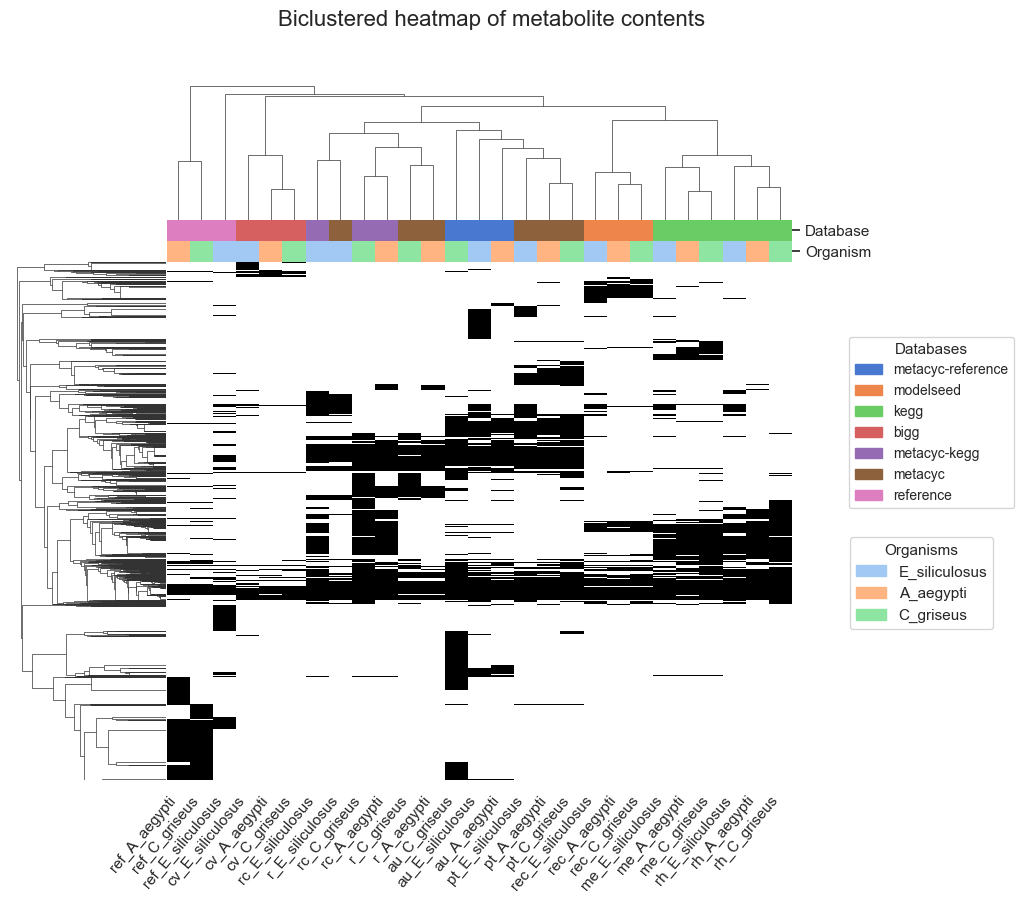

In [48]:
plot_biclustered_heatmap(binary_matrix, models, model2db, model2org, 'metabolite', 'figures/Figure5c.png')

### 5.6.6 Plotting PCoA

C:\Users\futbo\miniconda3\envs\eukaryo_methods_env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


PC1 (23.6%)

PC2 (18.3%)

PC3 (12.9%)



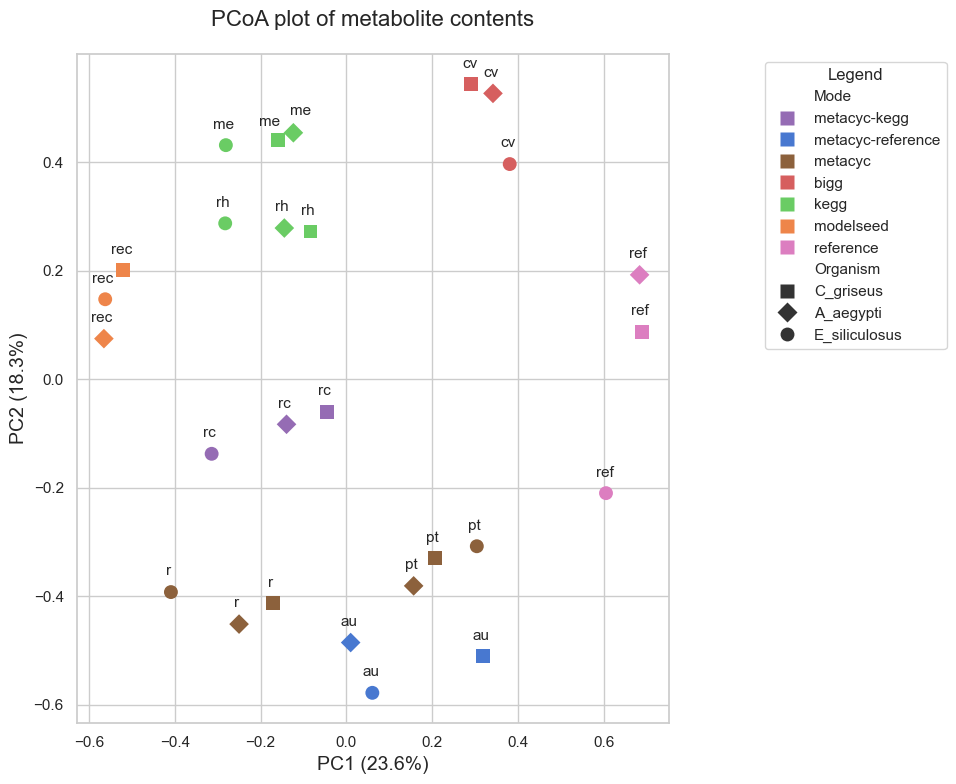

In [49]:
plot_pcoa(binary_matrix, model2db, model2org, 'metabolite', 0.0, 0.02, 'figures/Figure5d.png')

## 5.7 Model reaction content plotting (only AuReMe)

### 5.7.1 Reading complete reaction mapping table

In [195]:
# Path to complete reaction mapping table
complete_rxn_mapping_table_path = 'mappings/complete_rxn_mapping.csv'

# Read original csv
df = pd.read_csv(complete_rxn_mapping_table_path)

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Print first entries
print('Dataframe header: \n',df.head(5),'\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (113367, 10) 

Dataframe header: 
                            Original ID                         MNX_raw_SMej  \
0        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
1        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
2           _MENTHOL_DEHYDROGENASE_RXN           _MENTHOL_DEHYDROGENASE_RXN   
3  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   
4  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   

  transport                             MNX_SMej         model  \
0         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_A_aegypti   
1         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_C_griseus   
2         0           _MENTHOL_DEHYDROGENASE_RXN  rc_C_griseus   
3         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_A_aegypti   
4         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_C_griseus   

                          cleaned_SMen    MNX_SMen  MNX_manual    MNX_auto  

C:\Users\futbo\AppData\Local\Temp\ipykernel_4552\3734278522.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(complete_rxn_mapping_table_path)


### 5.7.2 Filtering models

In [196]:
# Define models to exclude (Note: au4_A_aegypti is excluded due to its large number of unmapped reactions)
excluded_models = ['rc_A_aegypti', 'rc_C_griseus', 'rc_E_siliculosus',
                   'pt_C_griseus', 'pt_E_siliculosus', 'r_A_aegypti',
                   'r_C_griseus', 'r_E_siliculosus', 'pt_A_aegypti','cv_E_siliculosus',
                   'cv_C_griseus', 'cv_A_aegypti','me_C_griseus', 'me_E_siliculosus', 'me_A_aegypti',
                   'rh_A_aegypti', 'rh_C_griseus', 'rh_E_siliculosus','rec_E_siliculosus',
                   'rec_C_griseus', 'rec_A_aegypti', 'ms_A_aegypti', 'ms_C_griseus', 'ms_E_siliculosus',
                   'au4_A_aegypti'] 

# Filtering
df = df[~df['model'].isin(excluded_models)]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')
print(unique_models)

Dataframe size:  (55714, 10) 

Number of unique reactions:  11370 

Number of unique models:  16 

['au3_E_siliculosus' 'au5_E_siliculosus' 'au_A_aegypti' 'au_C_griseus'
 'au_E_siliculosus' 'au2_A_aegypti' 'au2_C_griseus' 'au2_E_siliculosus'
 'au3_A_aegypti' 'au3_C_griseus' 'au4_E_siliculosus' 'au4_C_griseus'
 'au5_C_griseus' 'ref_A_aegypti' 'ref_C_griseus' 'ref_E_siliculosus']


### 5.7.3 Filtering transport reactions

In [197]:
# Filter transport reactions
df = df[df['transport']!=1]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (49234, 10) 

Number of unique reactions:  9387 

Number of unique models:  16 



### 5.7.4 Constructing binary matrix representing reaction presence

In [198]:
# Initialize a DataFrame with rows as models and columns as unique_rxns
binary_matrix = pd.DataFrame(0, index=unique_models, columns=unique_rxns)

for model in unique_models:
    # Get unique reactions for each model
    model_rxns = df[df['model'] == model]['Final ID'].dropna().unique()
    
    # Set the binary matrix values to 1 for the reactions in the current model
    binary_matrix.loc[model, model_rxns] = 1

# Fill NaNs with 0 for reactions that are not present in a model
binary_matrix = binary_matrix.fillna(0)
print(binary_matrix[1:10][1:10])

                   MNXR114877  MNXR114878  MNXR114879  MNXR107592  MNXR148054  \
au_A_aegypti                0           1           1           1           0   
au_C_griseus                0           1           1           1           0   
au_E_siliculosus            0           1           1           0           0   
au2_A_aegypti               0           1           1           1           0   
au2_C_griseus               0           1           1           1           0   
au2_E_siliculosus           0           1           1           0           0   
au3_A_aegypti               0           1           1           1           0   
au3_C_griseus               0           1           1           1           0   

                   MNXR114883  MNXR188214  MNXR148621  MNXR189139  MNXR107662  \
au_A_aegypti                0           1           1           0           1   
au_C_griseus                1           1           1           1           1   
au_E_siliculosus           

### 5.7.5 Labeling models for grouping

In [199]:
# Extract model names from the index of the binary matrix
models = binary_matrix.index

# Model to database mapping based on tool (model prefix)
tool2db = {'au': 'merged_original', 'au2':'annotation', 'au3':'merged_alternative', 'au4':'orth_original', 'au5':'orth_alternative', 'ref':'reference'}

model2db = {}
for model in models:
    prefix = model.split('_')[0]
    model2db[model] = tool2db[prefix]

# Model to organism mapping (based on model suffix)
model2org = {model: '_'.join(model.split('_')[-2:]) for model in models}

### 5.7.6 Plotting heatmap

<Figure size 1200x1000 with 0 Axes>

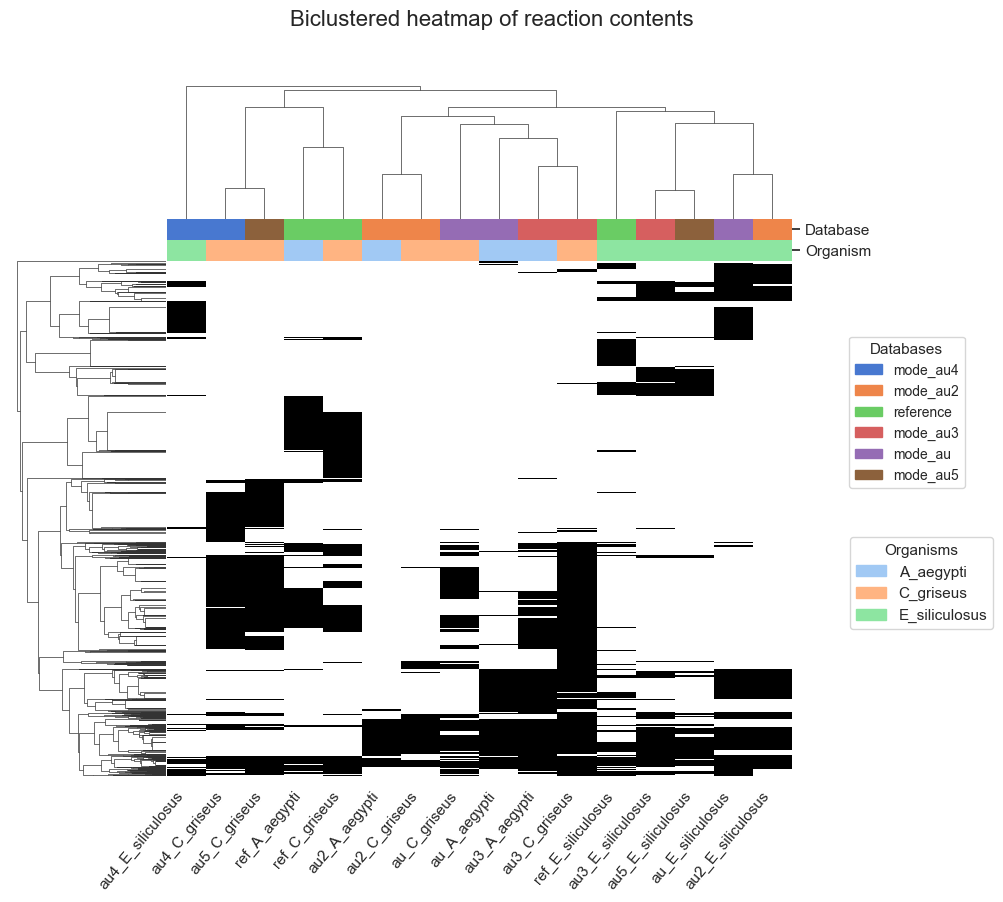

In [200]:
import sys
sys.setrecursionlimit(10000)  # Increase recursion depth
plot_biclustered_heatmap(binary_matrix, models, model2db, model2org, 'reaction', 'supplementary_material/AuReMe_test_reaction_heatmap.png')

### 5.7.7 Plotting PCoA

C:\Users\futbo\miniconda3\envs\eukaryo_methods_env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


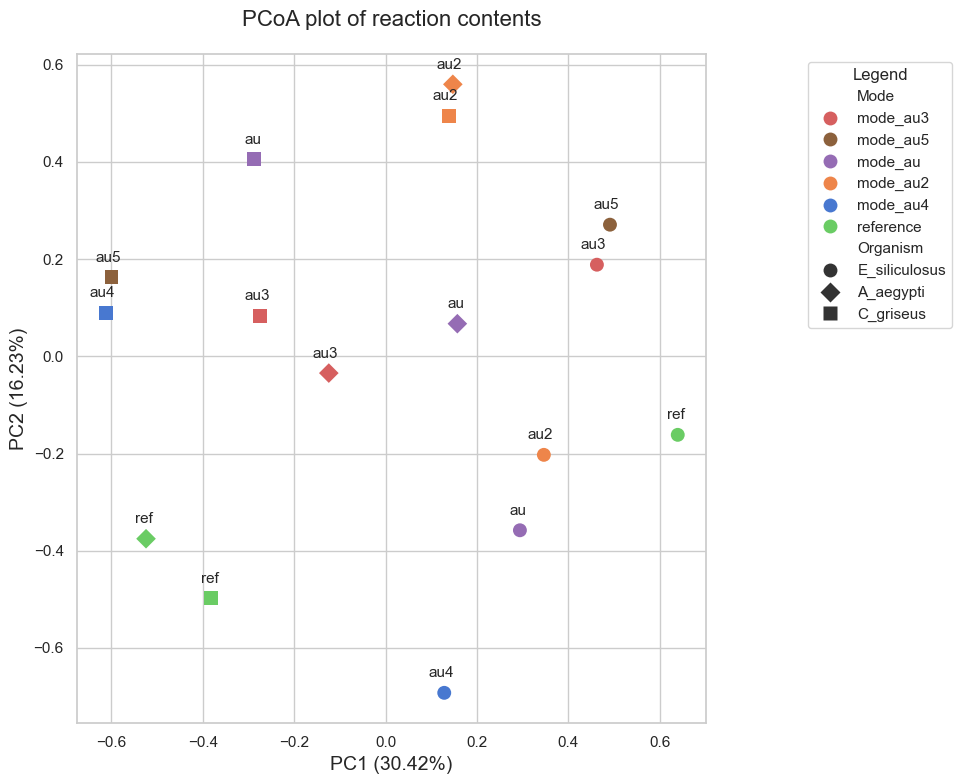

In [201]:
plot_pcoa(binary_matrix, model2db, model2org, 'reaction', 0.0, 0.02, 'supplementary_material/AuReMe_test_reaction_PCoA.png')

## 5.8 Model metabolite content plotting (only AuReMe)

### 5.8.1 Reading complete metabolite mapping table

In [202]:
# Read complete metabolite mapping table
complete_met_mapping_table_path = 'mappings/complete_met_mapping.csv'

# Read original csv
df = pd.read_csv(complete_met_mapping_table_path)

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Print first entries
print('Dataframe header: \n',df.head(5),'\n')

# Find unique metabolites
unique_mets = df['Final ID'].dropna().unique()
print('Number of unique metabolites: ', str(len(unique_mets)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (117284, 3) 

Dataframe header: 
                              Original ID             model    Final ID
0                           __MENTHOL[c]      rc_C_griseus    MNXM1346
1              +_5_oxo_1_2_campholide[c]      rc_A_aegypti  MNXM733701
2              +_5_oxo_1_2_campholide[c]      rc_C_griseus  MNXM733701
3              +-5-oxo-1-2-campholide[c]  rc_E_siliculosus  MNXM733701
4  1_2_DIPALMITOYLPHOSPHATIDYLCHOLINE[c]      rc_A_aegypti   MNXM32122 

Number of unique metabolites:  13238 

Number of unique models:  40 



### 5.8.2 Filtering models

In [203]:
# Define models to exclude (Note: au4_A_aegypti is excluded due to its large number of unmapped reactions)
excluded_models = ['rc_A_aegypti', 'rc_C_griseus', 'rc_E_siliculosus',
                   'pt_C_griseus', 'pt_E_siliculosus', 'r_A_aegypti',
                   'r_C_griseus', 'r_E_siliculosus', 'pt_A_aegypti','cv_E_siliculosus',
                   'cv_C_griseus', 'cv_A_aegypti','me_C_griseus', 'me_E_siliculosus', 'me_A_aegypti',
                   'rh_A_aegypti', 'rh_C_griseus', 'rh_E_siliculosus','rec_E_siliculosus',
                   'rec_C_griseus', 'rec_A_aegypti', 'ms_A_aegypti', 'ms_C_griseus', 'ms_E_siliculosus',
                   'au4_A_aegypti'] 


# Filtering excluded models
df = df[~df['model'].isin(excluded_models)]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique metabolites
unique_mets = df['Final ID'].dropna().unique()
print('Number of unique metabolites: ', str(len(unique_mets)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')
print(unique_models)

Dataframe size:  (58236, 3) 

Number of unique metabolites:  8551 

Number of unique models:  15 

['au2_A_aegypti' 'au2_C_griseus' 'au2_E_siliculosus' 'au3_A_aegypti'
 'au3_C_griseus' 'au3_E_siliculosus' 'au_A_aegypti' 'au_C_griseus'
 'au_E_siliculosus' 'au4_C_griseus' 'au4_E_siliculosus' 'au5_C_griseus'
 'ref_A_aegypti' 'ref_C_griseus' 'ref_E_siliculosus']


### 5.8.3 Constructing binary matrix representing metabolite presence

In [204]:
# Initialize a DataFrame with rows as models and columns as unique_mets
binary_matrix = pd.DataFrame(0, index=unique_models, columns=unique_mets)

for model in unique_models:
    # Get unique metabolites for each model
    model_mets = df[df['model'] == model]['Final ID'].dropna().unique()
    
    # Set the binary matrix values to 1 for the metabolites in the current model
    binary_matrix.loc[model, model_mets] = 1

# Fill NaNs with 0 for metabolites that are not present in a model
binary_matrix = binary_matrix.fillna(0)
print(binary_matrix[1:10][1:10])

                   MNXM1101068  MNXM1102376  MNXM3428  MNXM3429  MNXM5422  \
au2_E_siliculosus            1            0         0         0         0   
au3_A_aegypti                1            1         1         1         1   
au3_C_griseus                1            1         1         1         1   
au3_E_siliculosus            1            1         0         0         0   
au_A_aegypti                 1            0         0         0         0   
au_C_griseus                 1            1         1         1         1   
au_E_siliculosus             1            1         0         0         0   
au4_C_griseus                0            1         1         1         1   

                   phosphonate  10fthfglu_L  MNXM9575  MNXM10699  MNXM9666  \
au2_E_siliculosus            0            0         0          1         0   
au3_A_aegypti                0            0         0          0         0   
au3_C_griseus                0            0         0          1        

### 5.8.4 Labeling models for grouping

In [205]:
# Extract model names from the index of the binary matrix
models = binary_matrix.index

# Model to database mapping based on tool (model prefix)
tool2db = {'au': 'merged_original', 'au2':'annotation', 'au3':'merged_alternative', 'au4':'orth_original', 'au5':'orth_alternative', 'ref':'reference'}
model2db = {}
for model in models:
    prefix = model.split('_')[0]
    model2db[model] = tool2db[prefix]

# Model to organism mapping (based on model suffix)
model2org = {model: '_'.join(model.split('_')[-2:]) for model in models}

### 5.8.5 Plotting heatmap

<Figure size 1200x1000 with 0 Axes>

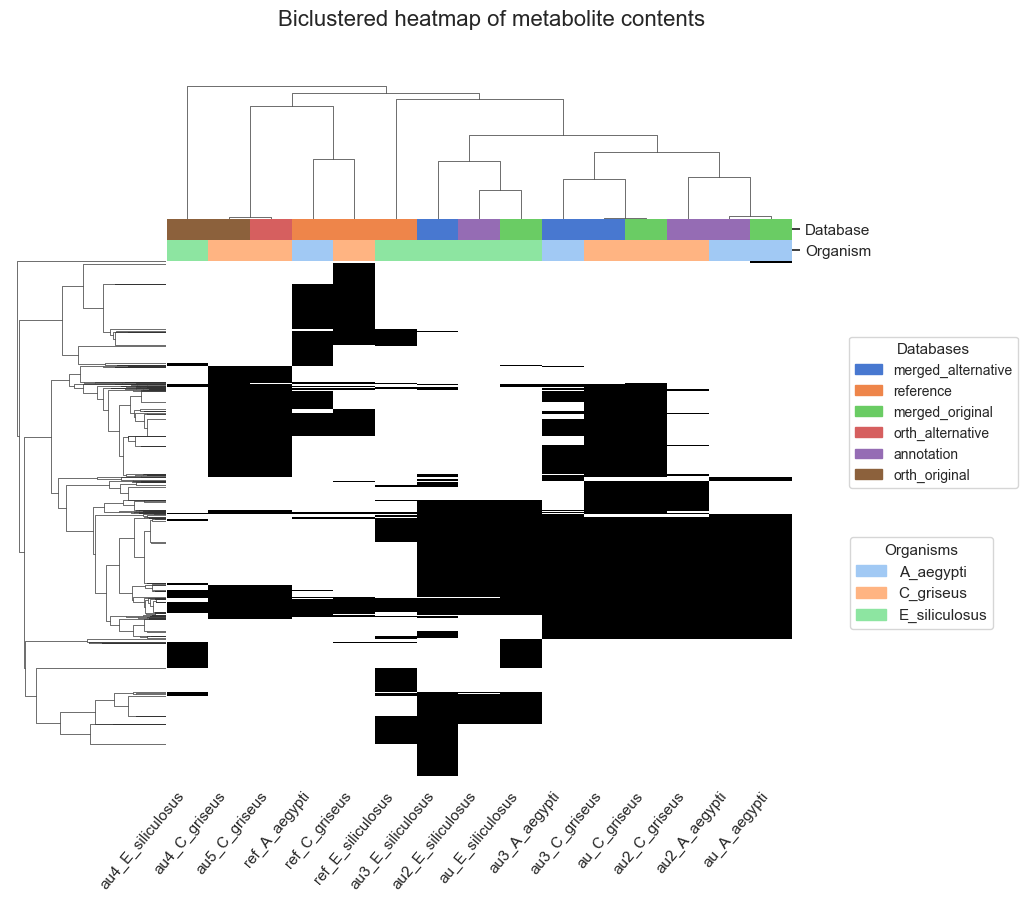

In [206]:
plot_biclustered_heatmap(binary_matrix, models, model2db, model2org, 'metabolite', 'supplementary_material/AuReMe_test_metabolite_heatmap.png')

### 5.8.6 Plotting PCoA

C:\Users\futbo\miniconda3\envs\eukaryo_methods_env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


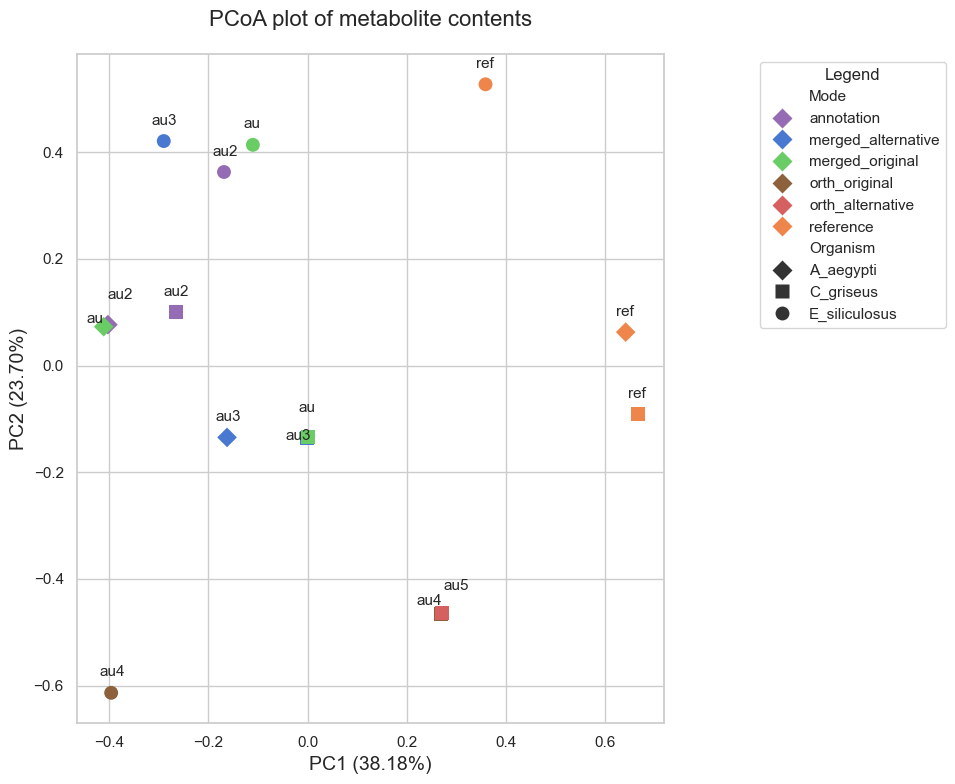

In [207]:
plot_pcoa(binary_matrix, model2db, model2org, 'metabolite', 0.0, 0.02, 'supplementary_material/AuReMe_test_metabolite_PCoA.png')

## 5.9 Plotting reaction PCoAs for each isolated organism 

### 5.9.1 Aedes aegypti

#### 5.9.1.1 Reading complete reaction mapping table

In [78]:
# Path to complete reaction mapping table
complete_rxn_mapping_table_path = 'mappings/complete_rxn_mapping.csv'

# Read original csv
df = pd.read_csv(complete_rxn_mapping_table_path)

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Print first entries
print('Dataframe header: \n',df.head(5),'\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (113367, 10) 

Dataframe header: 
                            Original ID                         MNX_raw_SMej  \
0        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
1        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
2           _MENTHOL_DEHYDROGENASE_RXN           _MENTHOL_DEHYDROGENASE_RXN   
3  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   
4  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   

  transport                             MNX_SMej         model  \
0         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_A_aegypti   
1         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_C_griseus   
2         0           _MENTHOL_DEHYDROGENASE_RXN  rc_C_griseus   
3         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_A_aegypti   
4         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_C_griseus   

                          cleaned_SMen    MNX_SMen  MNX_manual    MNX_auto  

C:\Users\futbo\AppData\Local\Temp\ipykernel_68900\3734278522.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(complete_rxn_mapping_table_path)


#### 5.9.1.2 Filtering models

In [79]:
# Define models to include
included_models = ['au_A_aegypti', 'rc_A_aegypti', 'rh_A_aegypti', 'r_A_aegypti', 
                   'rec_A_aegypti','me_A_aegypti', 'cv_A_aegypti', 'ref_A_aegypti',
                   'pt_A_aegypti']

# Filtering
df = df[df['model'].isin(included_models)]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')
print(unique_models)

Dataframe size:  (23124, 10) 

Number of unique reactions:  8516 

Number of unique models:  9 

['rc_A_aegypti' 'au_A_aegypti' 'r_A_aegypti' 'pt_A_aegypti' 'cv_A_aegypti'
 'me_A_aegypti' 'rh_A_aegypti' 'rec_A_aegypti' 'ref_A_aegypti']


#### 5.9.1.3 Filtering transport reactions

In [80]:
# Filter transport reactions
df = df[df['transport']!=1]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (22848, 10) 

Number of unique reactions:  8384 

Number of unique models:  9 



#### 5.9.1.4 Constructing binary matrix

In [81]:
# Initialize a DataFrame with rows as models and columns as unique_rxns
binary_matrix = pd.DataFrame(0, index=unique_models, columns=unique_rxns)

for model in unique_models:
    # Get unique reactions for each model
    model_rxns = df[df['model'] == model]['Final ID'].dropna().unique()
    
    # Set the binary matrix values to 1 for the reactions in the current model
    binary_matrix.loc[model, model_rxns] = 1

# Fill NaNs with 0 for reactions that are not present in a model
binary_matrix = binary_matrix.fillna(0)
print(binary_matrix[1:10][1:10])

               MNXR145864  MNXR114877  MNXR114878  MNXR114879  MNXR107592  \
r_A_aegypti             1           0           1           1           0   
pt_A_aegypti            0           0           1           1           1   
cv_A_aegypti            0           0           0           0           0   
rh_A_aegypti            0           0           0           0           1   
me_A_aegypti            0           0           0           0           1   
rec_A_aegypti           0           0           0           0           0   
ref_A_aegypti           0           0           0           0           0   

               MNXR148054  MNXR114882  MNXR188214  MNXR148621  MNXR107662  \
r_A_aegypti             1           1           1           0           0   
pt_A_aegypti            0           0           1           1           1   
cv_A_aegypti            0           0           0           0           0   
rh_A_aegypti            0           0           1           0           0  

#### 5.9.1.5 Labeling models for grouping

In [82]:
# Extract model names from the index of the binary matrix
models = binary_matrix.index

# Model to database mapping based on tool (model prefix)
tool2db = {'r': 'metacyc', 'rh': 'kegg', 'rc': 'metacyc-kegg', 'pt': 'metacyc', 
           'me': 'kegg', 'cv': 'bigg', 'rec': 'modelseed', 'au': 'metacyc-reference', 'ref': 'reference'}



# Model to database mapping based on tool (model prefix)
model2db = {}
for model in models:
    prefix = model.split('_')[0]
    model2db[model] = tool2db[prefix]

# Model to organism mapping (based on model suffix)
model2org = {model: '_'.join(model.split('_')[-2:]) for model in models}

#### 5.9.1.6 Plotting PCoA

C:\Users\futbo\miniconda3\envs\eukaryo_methods_env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


PC1 (27.6%)

PC2 (20.6%)

PC3 (14.2%)



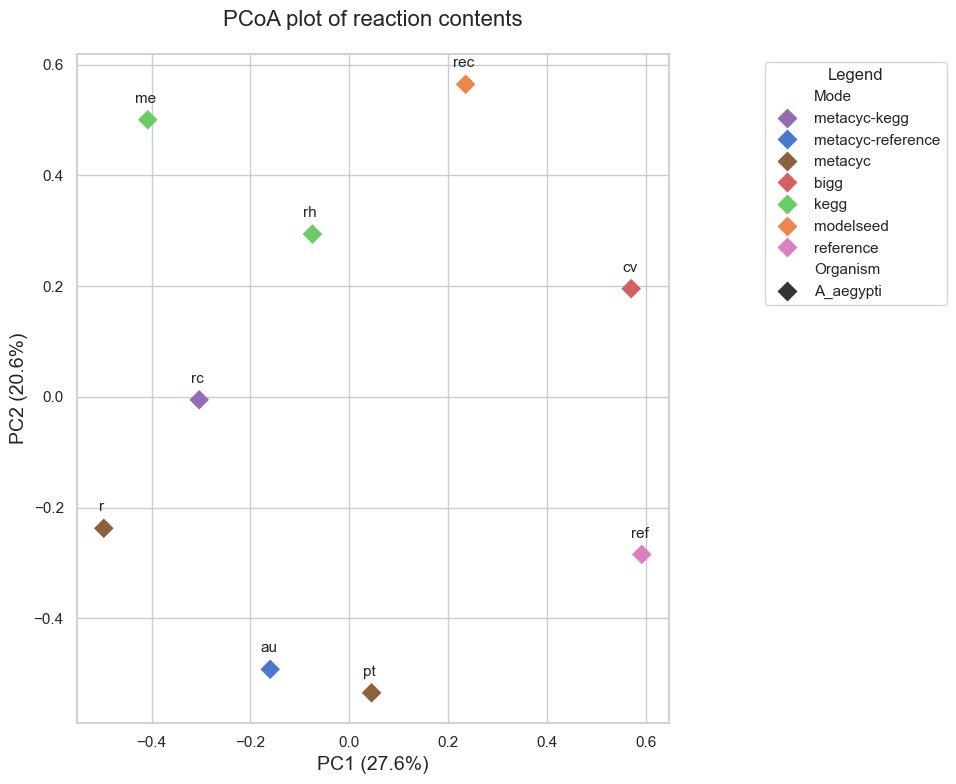

In [83]:
plot_pcoa(binary_matrix, model2db, model2org, 'reaction', 0.0, 0.02, None)

### 5.9.2 Cricetulus griseus

#### 5.9.2.1 Reading complete reaction mapping table

In [84]:
# Path to complete reaction mapping table
complete_rxn_mapping_table_path = 'mappings/complete_rxn_mapping.csv'

# Read original csv
df = pd.read_csv(complete_rxn_mapping_table_path)

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Print first entries
print('Dataframe header: \n',df.head(5),'\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (113367, 10) 

Dataframe header: 
                            Original ID                         MNX_raw_SMej  \
0        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
1        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
2           _MENTHOL_DEHYDROGENASE_RXN           _MENTHOL_DEHYDROGENASE_RXN   
3  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   
4  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   

  transport                             MNX_SMej         model  \
0         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_A_aegypti   
1         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_C_griseus   
2         0           _MENTHOL_DEHYDROGENASE_RXN  rc_C_griseus   
3         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_A_aegypti   
4         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_C_griseus   

                          cleaned_SMen    MNX_SMen  MNX_manual    MNX_auto  

C:\Users\futbo\AppData\Local\Temp\ipykernel_68900\3734278522.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(complete_rxn_mapping_table_path)


#### 5.9.2.2 Filtering models

In [85]:
# Define models to include
included_models = ['au_C_griseus', 'rc_C_griseus', 'rh_C_griseus', 'r_C_griseus', 
                   'rec_C_griseus','me_C_griseus', 'cv_C_griseus', 'ref_C_griseus',
                   'pt_C_griseus']

# Filtering
df = df[df['model'].isin(included_models)]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')
print(unique_models)

Dataframe size:  (26487, 10) 

Number of unique reactions:  9431 

Number of unique models:  9 

['rc_C_griseus' 'au_C_griseus' 'pt_C_griseus' 'r_C_griseus' 'cv_C_griseus'
 'me_C_griseus' 'rh_C_griseus' 'rec_C_griseus' 'ref_C_griseus']


#### 5.9.2.3 Filtering transport reactions

In [86]:
# Filter transport reactions
df = df[df['transport']!=1]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (25296, 10) 

Number of unique reactions:  9293 

Number of unique models:  9 



#### 5.9.2.4 Constructing binary matrix

In [87]:
# Initialize a DataFrame with rows as models and columns as unique_rxns
binary_matrix = pd.DataFrame(0, index=unique_models, columns=unique_rxns)

for model in unique_models:
    # Get unique reactions for each model
    model_rxns = df[df['model'] == model]['Final ID'].dropna().unique()
    
    # Set the binary matrix values to 1 for the reactions in the current model
    binary_matrix.loc[model, model_rxns] = 1

# Fill NaNs with 0 for reactions that are not present in a model
binary_matrix = binary_matrix.fillna(0)
print(binary_matrix[1:10][1:10])

               MNXR145864  MNXR107350  MNXR114877  MNXR114878  MNXR114879  \
pt_C_griseus            0           0           0           1           1   
r_C_griseus             1           1           0           1           0   
cv_C_griseus            0           0           0           0           0   
me_C_griseus            0           0           0           0           0   
rh_C_griseus            0           0           0           0           0   
rec_C_griseus           0           0           0           0           0   
ref_C_griseus           0           0           0           0           0   

               MNXR107592  MNXR148054  MNXR114882  MNXR148641  MNXR114883  \
pt_C_griseus            1           0           0           0           1   
r_C_griseus             0           1           1           0           1   
cv_C_griseus            0           0           0           0           0   
me_C_griseus            0           0           0           0           0  

#### 5.9.2.5 Labeling models for grouping

In [88]:
# Extract model names from the index of the binary matrix
models = binary_matrix.index

# Model to database mapping based on tool (model prefix)
tool2db = {'r': 'metacyc', 'rh': 'kegg', 'rc': 'metacyc-kegg', 'pt': 'metacyc', 
           'me': 'kegg', 'cv': 'bigg', 'rec': 'modelseed', 'au': 'metacyc-reference', 'ref': 'reference'}

model2db = {}
for model in models:
    prefix = model.split('_')[0]
    model2db[model] = tool2db[prefix]

# Model to organism mapping (based on model suffix)
model2org = {model: '_'.join(model.split('_')[-2:]) for model in models}

#### 5.9.2.6 Plotting PCoA

C:\Users\futbo\miniconda3\envs\eukaryo_methods_env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


PC1 (21.2%)

PC2 (19.0%)

PC3 (13.7%)



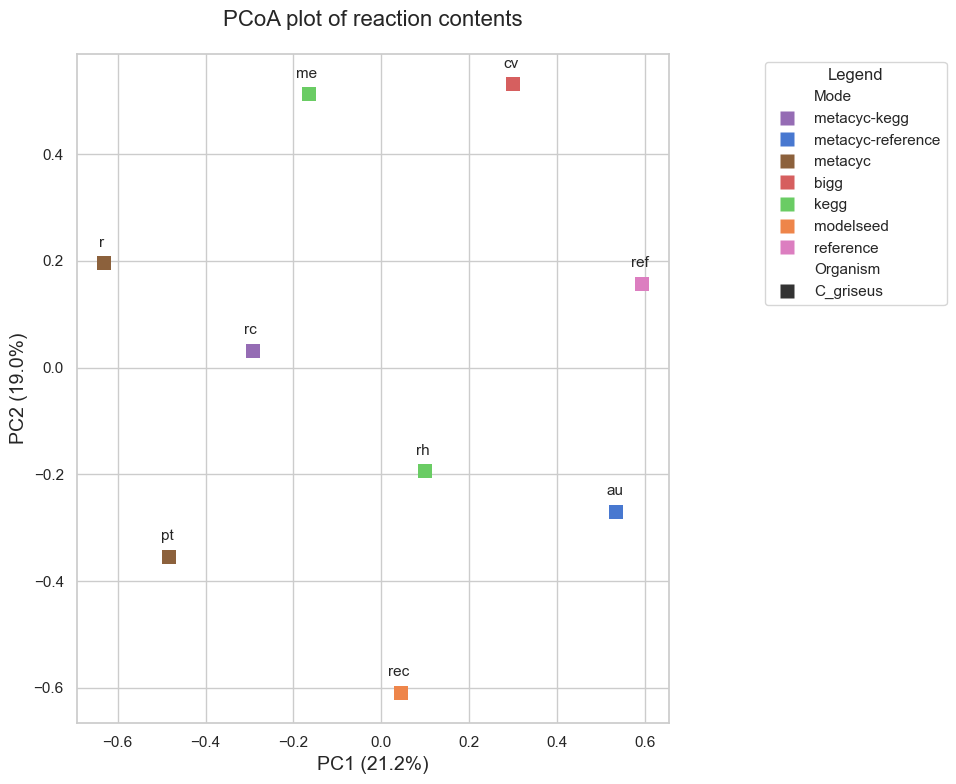

In [89]:
plot_pcoa(binary_matrix, model2db, model2org, 'reaction', 0.0, 0.02, None)

### 5.9.3 Ectocarpus siliculosus

#### 5.9.3.1 Reading complete reaction mapping table

In [90]:
# Path to complete reaction mapping table
complete_rxn_mapping_table_path = 'mappings/complete_rxn_mapping.csv'

# Read original csv
df = pd.read_csv(complete_rxn_mapping_table_path)

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Print first entries
print('Dataframe header: \n',df.head(5),'\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (113367, 10) 

Dataframe header: 
                            Original ID                         MNX_raw_SMej  \
0        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
1        _LIMONENE_7_MONOOXYGENASE_RXN        _LIMONENE_7_MONOOXYGENASE_RXN   
2           _MENTHOL_DEHYDROGENASE_RXN           _MENTHOL_DEHYDROGENASE_RXN   
3  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   
4  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN   

  transport                             MNX_SMej         model  \
0         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_A_aegypti   
1         0        _LIMONENE_7_MONOOXYGENASE_RXN  rc_C_griseus   
2         0           _MENTHOL_DEHYDROGENASE_RXN  rc_C_griseus   
3         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_A_aegypti   
4         0  1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN  rc_C_griseus   

                          cleaned_SMen    MNX_SMen  MNX_manual    MNX_auto  

C:\Users\futbo\AppData\Local\Temp\ipykernel_68900\3734278522.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(complete_rxn_mapping_table_path)


#### 5.9.3.2 Filtering models

In [91]:
# Define models to include
included_models = ['au_E_siliculosus', 'rc_E_siliculosus', 'rh_E_siliculosus', 'r_E_siliculosus', 
                   'rec_E_siliculosus','me_E_siliculosus', 'cv_E_siliculosus', 'ref_E_siliculosus',
                   'pt_E_siliculosus']

# Filtering
df = df[df['model'].isin(included_models)]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')
print(unique_models)

Dataframe size:  (18712, 10) 

Number of unique reactions:  7306 

Number of unique models:  9 

['rc_E_siliculosus' 'au_E_siliculosus' 'pt_E_siliculosus'
 'r_E_siliculosus' 'cv_E_siliculosus' 'me_E_siliculosus'
 'rh_E_siliculosus' 'rec_E_siliculosus' 'ref_E_siliculosus']


#### 5.9.3.3 Filtering transport reactions

In [92]:
# Filter transport reactions
df = df[df['transport']!=1]

# Print dataframe size
print('Dataframe size: ', str(df.shape), '\n')

# Find unique reactions
unique_rxns = df['Final ID'].dropna().unique()
print('Number of unique reactions: ', str(len(unique_rxns)), '\n')

# Find unique models
unique_models = df['model'].unique()
print('Number of unique models: ', str(len(unique_models)), '\n')

Dataframe size:  (18311, 10) 

Number of unique reactions:  7134 

Number of unique models:  9 



#### 5.9.3.4 Constructing binary matrix

In [93]:
# Initialize a DataFrame with rows as models and columns as unique_rxns
binary_matrix = pd.DataFrame(0, index=unique_models, columns=unique_rxns)

for model in unique_models:
    # Get unique reactions for each model
    model_rxns = df[df['model'] == model]['Final ID'].dropna().unique()
    
    # Set the binary matrix values to 1 for the reactions in the current model
    binary_matrix.loc[model, model_rxns] = 1

# Fill NaNs with 0 for reactions that are not present in a model
binary_matrix = binary_matrix.fillna(0)
print(binary_matrix[1:10][1:10])

                   MNXR114877  MNXR114878  MNXR114879  MNXR138245  MNXR114882  \
pt_E_siliculosus            0           1           1           0           0   
r_E_siliculosus             0           1           0           0           0   
cv_E_siliculosus            0           0           0           0           0   
me_E_siliculosus            0           0           0           0           0   
rh_E_siliculosus            0           0           0           1           0   
rec_E_siliculosus           0           0           0           1           0   
ref_E_siliculosus           1           1           1           0           0   

                   MNXR114883  MNXR188214  MNXR107662  MNXR190768  MNXR192159  \
pt_E_siliculosus            1           1           1           1           0   
r_E_siliculosus             0           0           0           0           1   
cv_E_siliculosus            0           1           0           0           0   
me_E_siliculosus           

#### 5.9.3.5 Labeling models for grouping

In [94]:
# Extract model names from the index of the binary matrix
models = binary_matrix.index

# Model to database mapping based on tool (model prefix)
tool2db = {'r': 'metacyc', 'rh': 'kegg', 'rc': 'metacyc-kegg', 'pt': 'metacyc', 
           'me': 'kegg', 'cv': 'bigg', 'rec': 'modelseed', 'au': 'metacyc-reference', 'ref': 'reference'}

model2db = {}
for model in models:
    prefix = model.split('_')[0]
    model2db[model] = tool2db[prefix]

# Model to organism mapping (based on model suffix)
model2org = {model: '_'.join(model.split('_')[-2:]) for model in models}

#### 5.9.3.6 Plotting PCoA

C:\Users\futbo\miniconda3\envs\eukaryo_methods_env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


PC1 (24.0%)

PC2 (17.4%)

PC3 (16.2%)



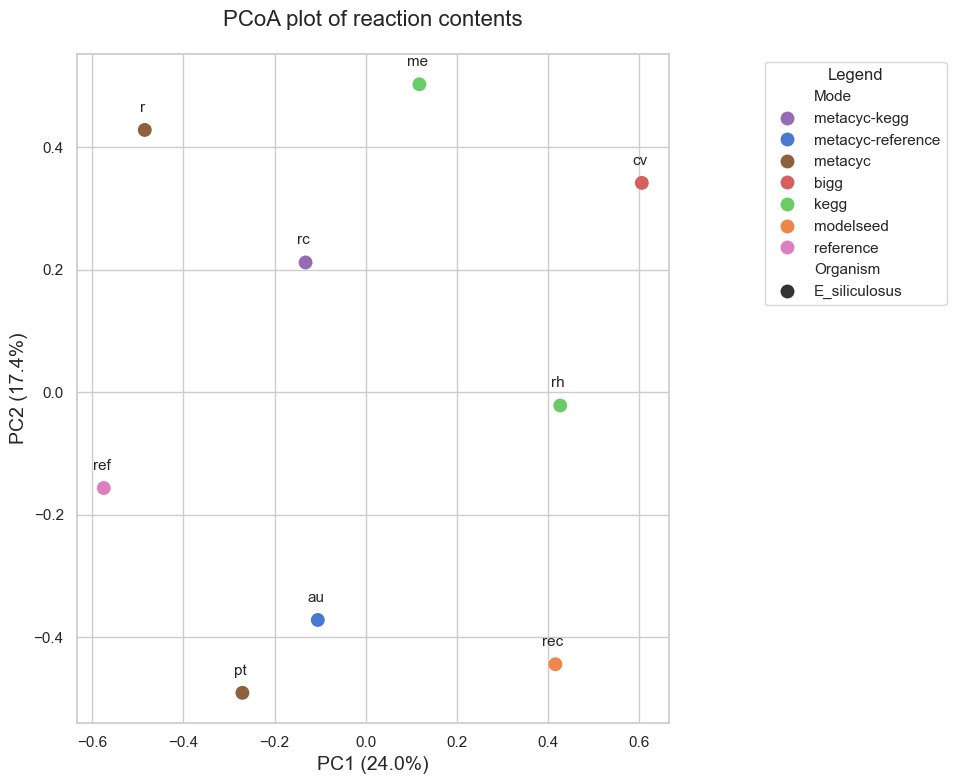

In [95]:
plot_pcoa(binary_matrix, model2db, model2org, 'reaction', 0.0, 0.02, None)